This notebook produces the following figures that are used in the manuscript:

1. Visual convergence of the solution of $\text{KdVH}(\tau)$ to the KdV solution using a time-stepping method.
2. Traveling Waves Using the Petviashvili Method.
3. Quantitative comparison of the asymptotic-preserving (AP) property by different time-stepping methods.
4. Asymptotic Accuracy Plots.
5. Error growth plots for different methods, with and without RK relaxation, applied to $\text{KdVH}(\tau)$, with the exact solution computed using the Petviashvili method.
6. RK relaxation on $\text{KdVH}(\tau)$ to verify linear and quadratic error convergence using conservative versus non-conservative methods.

In [1]:
include("code.jl")

  Activating project at `~/Library/CloudStorage/GoogleDrive-abhi070491@gmail.com/My Drive/Research/Current Projects/2024_kdvh_RR`


plot_kdvh_traveling_approximation (generic function with 1 method)

In [2]:
using CairoMakie
set_theme!(theme_latexfonts();
           fontsize = 20,
           Lines = (linewidth = 3, cycle = Cycle([:color, :linestyle], covary = true),),
           markersize = 16)

### Visual convergence of the solution of $\text{KdVH}(\tau)$ to the KdV solution.

  1.086302 seconds (3.64 M allocations: 245.703 MiB, 3.75% gc time, 84.29% compilation time)
  1.558541 seconds (3.95 M allocations: 266.658 MiB, 3.49% gc time, 78.66% compilation time)
  0.330732 seconds (36.39 k allocations: 6.610 MiB)
  0.326799 seconds (36.39 k allocations: 6.610 MiB)


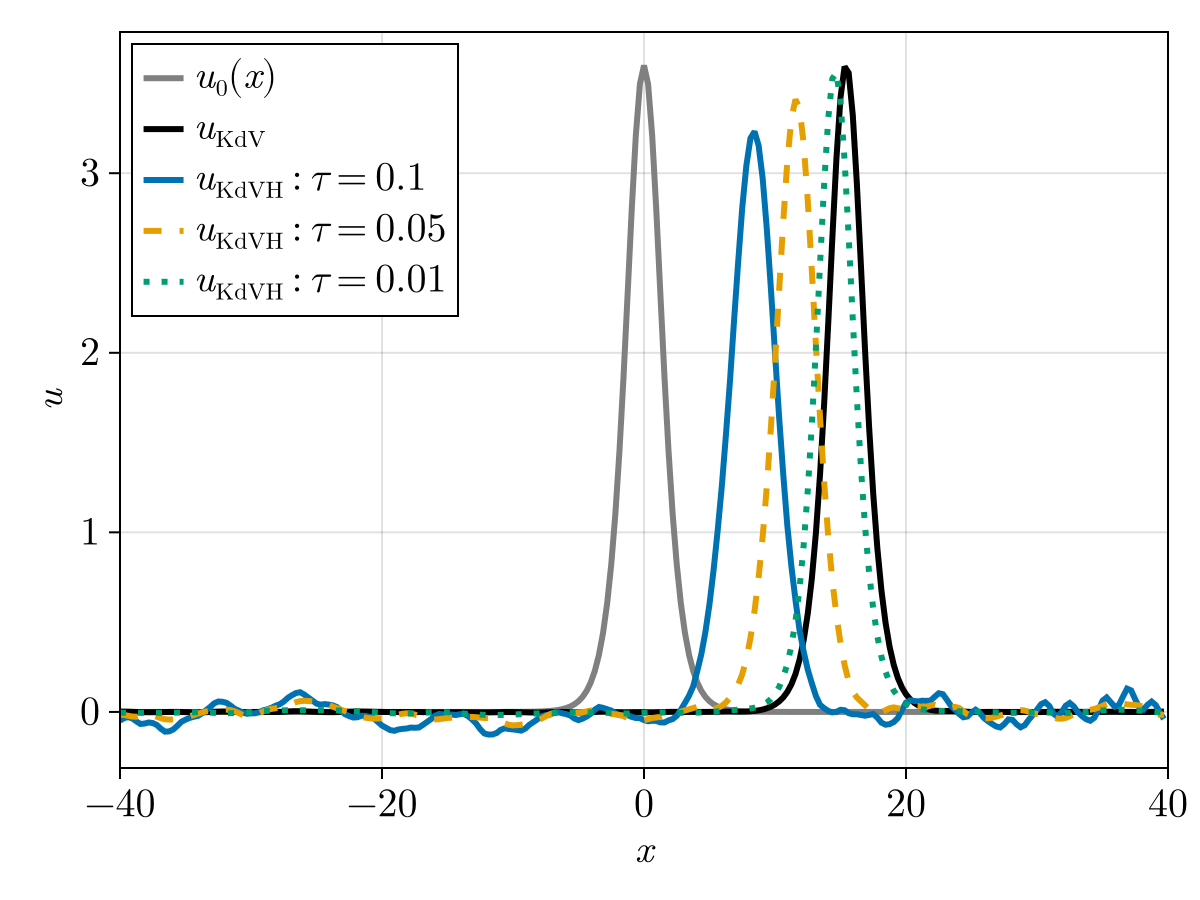

In [3]:
domain_traversals = 1.2; # This will determine the final time = domain_traversals*(xmax-xmin)/c
accuracy_order = 1; N = 2^8;
alg = ARS443(); dt = 0.01;
τs = [1.0e-1, 5.0e-2, 1.0e-2]

# Initialization of physical and numerical parameters
(; xmin, xmax, c) = solitary_wave_setup()
tspan = (0.0, domain_traversals * (xmax - xmin) / c)

D1 = upwind_operators(periodic_derivative_operator;
                      derivative_order = 1, accuracy_order,
                      xmin, xmax, N)


# Setup plot
fig_KdVH_KdV = Figure()
ax = Axis(fig_KdVH_KdV[1, 1]; xlabel = L"x", ylabel = L"u")

# KdV
let equation = KdV()
    (; q0, parameters) = setup(solitary_wave_solution, equation,
                               tspan, D1)
    @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                           rhs_nonstiff!,
                           q0, tspan, parameters, alg;
                           dt)

    x = grid(parameters.D1)
    lines!(ax, x, get_u(sol.u[begin], equation);
           label = L"u_0(x)", color = :gray)
    lines!(ax, x, get_u(sol.u[end], equation);
           label = L"u_\mathrm{KdV}", color = :black)
end

# Assuming `τs` is an array of different values of τ=
for (i, τ) in enumerate(τs)
    # HyperbolizedKdV with IMEX
    let equation = HyperbolizedKdV(τ)
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt)

        x = grid(parameters.D1)
        # Use label with τ and different line styles
        lines!(ax, x, get_u(sol.u[end], equation);
               label = L"u_\mathrm{KdVH}: \tau = %$(τ)")
    end
end

axislegend(ax, position = :lt)
xlims!(ax, xmin, xmax)
fig_KdVH_KdV

In [4]:
# Define paths
save_path_1 = joinpath(@__DIR__, "img")
save_path_2 = joinpath(@__DIR__, "tables_data")

# Create directories if they do not exist
if !isdir(save_path_1)
    mkdir(save_path_1)
end

if !isdir(save_path_2)
    mkdir(save_path_2)
end

In [5]:
save(joinpath(save_path_1, "KdVH_convergence_KdV_ARS443.pdf"), fig_KdVH_KdV)

CairoMakie.Screen{PDF}


### Traveling Waves Using the Petviashvili Method.

In [6]:
# Exact solution for the traveling wave solution for the KdV
function kdv_solution(ξ, c)
    A = 3 * c
    K = sqrt(3 * A) / 6

    return A / cosh(K * ξ)^2
end

kdv_solution (generic function with 1 method)

In [7]:
function petviashvili_kdv(; xmin = - 40.0, xmax = 40.0, c = 1/3, N = 2^8, maxiter = 1000, tol = 1.0e-14)

    D = fourier_derivative_operator(xmin, xmax, N)

    L = c * I - D^2
    N_fun(u) = 0.5 .* u.^2
    γ = 2
    # Initialization
    x = grid(D)
    u0 = exp.(-x.^2)
    # Iteration
    u = copy(u0)
    for iter in 1:maxiter
        res = norm(L * u - N_fun(u), Inf)
        #println(res)
        if res < tol
            @info "Converged" iter res
            break
        end
        m = integrate(u .* (L * u), D) / integrate(u .* N_fun(u), D)
        u = m^γ * (L \ N_fun(u))
    end

    return (; x, u)
end

petviashvili_kdv (generic function with 1 method)

In [8]:
function petviashvili_kdvh(; xmin = - 40.0, xmax = 40.0, λ = 100, c = 1/3, N = 2^8, maxiter = 1000, tol = 1.0e-14)
    # Setup numerical discretization with periodic boundary conditions

    D = fourier_derivative_operator(xmin, xmax, N)
    D1 = Matrix(D);
    L = (λ^2*c/((λ+c)*(λ-c^2))) .* I - D^2

    N_fun(u) = (λ^2/((λ+c)*(λ-c^2))) .*0.5 .* u.^2 + (c/(λ-c^2)) .* D1 * (u .* (D1 * u))
    γ = 2
    # Initialization
    x = grid(D)
    u0 = exp.(-x.^2)

    # Iteration
    u = copy(u0)
    for iter in 1:maxiter
        res = norm(L * u - N_fun(u), Inf)
        #println(res)
        if res < tol
            @info "Converged" iter=iter res=res
            break
        end
        m = integrate(u .* (L * u), D) / integrate(u .* N_fun(u), D)
        u = m^γ * (L \ N_fun(u))
    end
    return (; x, u)
end

petviashvili_kdvh (generic function with 1 method)

#### Plot

┌ Info: Converged
│   iter = 62
└   res = 6.966649479522857e-15
┌ Info: Error wrt KdV solution
└   norm(u_kdv - u_ana, Inf) = 3.736445463143145e-10
┌ Info: Converged
│   iter = 54
└   res = 7.668487006787357e-15
┌ Info: Error wrt KdV solution
└   norm(u_kdvh_1 - u_ana, Inf) = 0.143596533919097
┌ Info: Converged
│   iter = 58
└   res = 9.159339953157541e-15
┌ Info: Error wrt KdV solution
└   norm(u_kdvh_2 - u_ana, Inf) = 0.07589301216250632
┌ Info: Converged
│   iter = 61
└   res = 8.548717289613705e-15
┌ Info: Error wrt KdV solution
└   norm(u_kdvh_3 - u_ana, Inf) = 0.01593598115019218


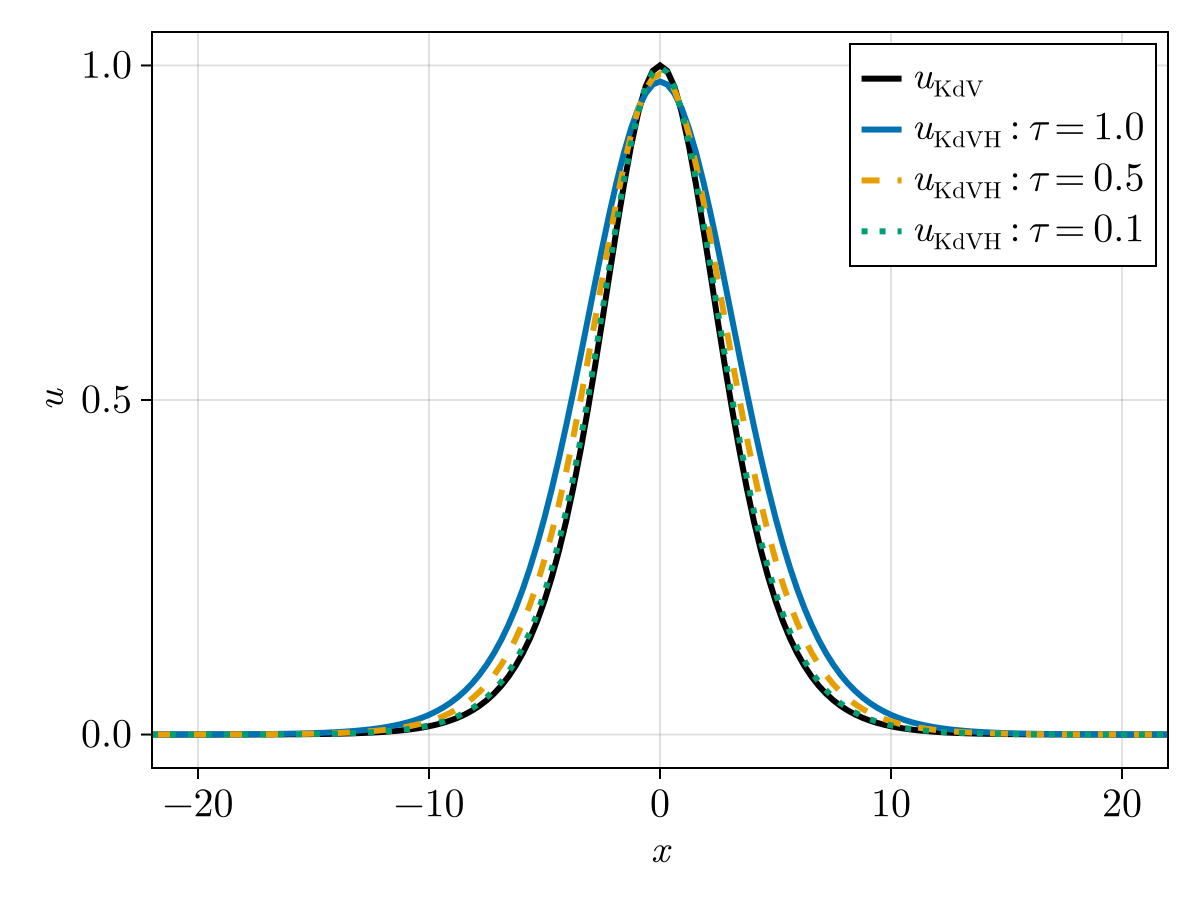

In [9]:
c = 1/3;
x, u_kdv = petviashvili_kdv(; xmin = - 40.0, xmax = 40.0, c = c, N = 2^8, maxiter = 1000, tol = 1.0e-14)
u_ana = kdv_solution.(x, c)

@info "Error wrt KdV solution" norm(u_kdv - u_ana, Inf)

τ1 = 1.0e-0; λ1 = 1/τ1;
x, u_kdvh_1 = petviashvili_kdvh(; xmin = - 40.0, xmax = 40.0, λ = λ1, c = c, N = 2^8, maxiter = 1000, tol = 1.0e-14)
@info "Error wrt KdV solution" norm(u_kdvh_1 - u_ana, Inf)

τ2 = 5.0e-1; λ2 = 1/τ2;
x, u_kdvh_2 = petviashvili_kdvh(; xmin = - 40.0, xmax = 40.0, λ = λ2, c = c, N = 2^8, maxiter = 1000, tol = 1.0e-14)
@info "Error wrt KdV solution" norm(u_kdvh_2 - u_ana, Inf)

τ3 = 1.0e-1; λ3 = 1/τ3;
x, u_kdvh_3 = petviashvili_kdvh(; xmin = - 40.0, xmax = 40.0, λ = λ3, c = c, N = 2^8, maxiter = 1000, tol = 1.0e-14)
@info "Error wrt KdV solution" norm(u_kdvh_3 - u_ana, Inf)

# Visualization
xL = -7*π; xR = 7*π
fig_sol_wave = Figure()
ax = Axis(fig_sol_wave[1, 1]; xlabel = L"x", ylabel = L"u")
lines!(ax, x, u_ana; label = L"u_\mathrm{KdV}", color = :black)
lines!(ax, x, u_kdvh_1; label = L"u_\mathrm{KdVH}: \tau = %$(τ1)")
lines!(ax, x, u_kdvh_2; label = L"u_\mathrm{KdVH}: \tau = %$(τ2)")
lines!(ax, x, u_kdvh_3; label = L"u_\mathrm{KdVH}: \tau = %$(τ3)")
axislegend(ax, position = :rt)
xlims!(ax, xL, xR)
fig_sol_wave

In [10]:
save(joinpath(save_path_1, "solitary_wave_kdv_kdvh.pdf"), fig_sol_wave)

CairoMakie.Screen{PDF}


### Quantitative comparison of the asymptotic-preserving (AP) property by different time-stepping methods.

In [42]:
# Convergence in the hyperbolic relaxation parameter
function save_table_as_latex(τs, errors_u, eoc_u, errors_v, eoc_v, errors_w, eoc_w, filename)
    data = hcat(τs, errors_u, eoc_u, errors_v, eoc_v, errors_w, eoc_w)
    header = ["\tau", "error u", "EOC u", "error v", "EOC v", "error w", "EOC w"]  # Use LaTeX math mode for τ
    kwargs = (; header, formatters=(ft_printf("%.2e", [1, 2, 4, 6]),
                                    ft_printf("%.2f", [3, 5, 7])))

    open(filename, "w") do io
        println(io, "\\begin{table}[ht]")  # Start the table environment
        println(io, "\\centering")         # Center the table
        pretty_table(io, data; kwargs..., backend=Val(:latex))
        println(io, "\\caption{....}")  # Optional caption
        println(io, "\\end{table}")     # End the table environment
    end
end

function get_uvw(q, equations::HyperbolizedKdV)
    N = length(q) ÷ 3
    u = view(q, (0 * N + 1):(1 * N))
    v = view(q, (1 * N + 1):(2 * N))
    w = view(q, (2 * N + 1):(3 * N))
    return (; u = u,v = v, w = w)
end

function AP_property_imex(; latex = false,
                            save_latex_table = true,
                            domain_traversals = 0.25,
                            N = 2^8,
                            spatial_discretization = periodic_derivative_operator,
                            polydeg = 7,
                            Nx = 2^5,
                            alg = ARS443(),
                            ImEx_name = "ARS443",
                            dt = 0.005,
                            kwargs...)
    # Initialization of physical and numerical parameters
    (; xmin, xmax, c) = solitary_wave_setup()
    tspan = (0.0, domain_traversals * (xmax - xmin) / c)

    if spatial_discretization === periodic_derivative_operator
        D1 = upwind_operators(periodic_derivative_operator;
                              derivative_order = 1, accuracy_order = 8,
                              xmin, xmax, N)
    elseif spatial_discretization === LegendreDerivativeOperator
        D_local = LegendreDerivativeOperator(-1.0, 1.0, polydeg + 1)
        mesh = UniformPeriodicMesh1D(; xmin, xmax, Nx)
        D1 = PeriodicUpwindOperators(
            couple_discontinuously(D_local, mesh, Val(:minus)),
            couple_discontinuously(D_local, mesh, Val(:central)),
            couple_discontinuously(D_local, mesh, Val(:plus))
        )
    elseif spatial_discretization === fourier_derivative_operator
        D1 = fourier_derivative_operator(xmin, xmax, N)
    end


    # τs = [1.0e-1, 1.0e-2, 1.0e-3, 1.0e-4, 1.0e-5, 1.0e-6, 1.0e-7,
    #      1.0e-8, 1.0e-9, 1.0e-10, 1.0e-11, 1.0e-12]
    τs = [1.0e-1, 1.0e-3, 1.0e-5, 1.0e-7, 1.0e-9]


    errors_u_num = Float64[]
    errors_v_num = Float64[]
    errors_w_num = Float64[]

    u_ref_num = let
        equation = KdV()
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt = dt, kwargs...)
        get_u(sol.u[end], equation)
    end

    # Computing the numerical reference solution for the auxiliary variables using the derivative operator
    v_ref_num = similar(u_ref_num)
    w_ref_num = similar(u_ref_num)
    if spatial_discretization === periodic_derivative_operator
        mul!(v_ref_num, D1.minus, u_ref_num)
        mul!(w_ref_num, D1.central, v_ref_num)
    elseif spatial_discretization === LegendreDerivativeOperator
        mul!(v_ref_num, D1.minus, u_ref_num)
        mul!(w_ref_num, D1.central, v_ref_num)
    elseif spatial_discretization === fourier_derivative_operator
        mul!(v_ref_num, D1, u_ref_num)
        mul!(w_ref_num, D1, v_ref_num)
    end

    for τ in τs
        equation = HyperbolizedKdV(τ)
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt = dt, kwargs...)

        x = grid(parameters.D1)
        uvw = get_uvw(sol.u[end], equation)

        error_u = integrate(abs2, uvw.u - u_ref_num, parameters.D1) |> sqrt
        error_v = integrate(abs2, uvw.v - v_ref_num, parameters.D1) |> sqrt
        error_w = integrate(abs2, uvw.w - w_ref_num, parameters.D1) |> sqrt
        push!(errors_u_num, error_u); push!(errors_v_num, error_v); push!(errors_w_num, error_w)
    end

    let
        errors_u = errors_u_num
        errors_v = errors_v_num
        errors_w = errors_w_num
        @info "Errors with respect to the numerical KdV solution"
        eoc_u = compute_eoc(inv.(τs), errors_u)
        eoc_v = compute_eoc(inv.(τs), errors_v)
        eoc_w = compute_eoc(inv.(τs), errors_w)

        # Change the name of the file here when use different time-stepping methods
        filename = joinpath(save_path_2, ImEx_name * "_errors_num.tex")
        #filename = "Figures/" * ImEx_name * "_errors_num.tex"
        if save_latex_table
            save_table_as_latex(τs, errors_u, eoc_u, errors_v, eoc_v, errors_w, eoc_w, filename)
        end

        data = hcat(τs, errors_u, eoc_u, errors_v, eoc_v, errors_w, eoc_w)
        header = ["\tau", "error u", "EOC u", "error v", "EOC v", "error w", "EOC w"]  # Use LaTeX math mode for τ
        kwargs = (; header, formatters=(ft_printf("%.2e", [1, 2, 4, 6]),
                                    ft_printf("%.2f", [3, 5, 7])))
        pretty_table(data; kwargs...)
        if latex
            pretty_table(data; kwargs..., backend=Val(:latex))
        end
    end

end

AP_property_imex (generic function with 1 method)

#### AP property by type I methods.

In [43]:
# AP results by SSP2-IMEX(2,2,2)
#SSP2-IMEX(2,2,2): 2nd order L-stable type I ImEX-RK, explicit part - NOT FSAL, implicit part - NOT SA; NOT GSA.

AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = SSP2ImEx222(),
                   ImEx_name = "SSP2ImEx222",
                   dt = 0.005)

  0.378198 seconds (6.90 k allocations: 12.125 MiB)
  0.589227 seconds (22.58 k allocations: 35.404 MiB, 1.03% gc time)
  0.551213 seconds (22.57 k allocations: 35.404 MiB)
  2.958635 seconds (22.57 k allocations: 64.488 MiB)
  3.038648 seconds (22.60 k allocations: 79.027 MiB, 0.21% gc time)
  3.056993 seconds (22.58 k allocations: 79.024 MiB)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.77e+00 │   NaN │ 3.13e+00 │   NaN │ 3.61e+00 │   NaN │
│ 1.00e-03 │ 5.35e-02 │  0.92 │ 4.47e-02 │  0.92 │ 5.55e-02 │  0.91 │
│ 1.00e-05 │ 5.37e-04 │  1.00 │ 8.96e-03 │  0.35 │ 1.63e-02 │  0.27 │
│ 1.00e-07 │ 5.37e-06 │  1.00 │ 9.51e-03 │ -0.01 │ 1.69e-02 │ -0.01 │
│ 1.00e-09 │ 5.39e-08 │  1.00 │ 9.52e-03 │ -0.00 │ 1.69e-02 │ -0.00 │
└──────────┴──────────┴───────┴──────────┴───────┴──────────┴───────┘


[ Info: Errors with respect to the numerical KdV solution


In [47]:
# AP results by SSP2-IMEX(3,3,2)
# SSP2-IMEX(3,3,2): 2nd order L-stable type I ImEX-RK, explicit part - NOT FSAL, implicit part - SA; NOT GSA.

AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = SSP2ImEx332(),
                   ImEx_name = "SSP2ImEx332",
                   dt = 0.005)

  0.594528 seconds (10.35 k allocations: 18.936 MiB)
  0.802118 seconds (26.02 k allocations: 45.480 MiB)
  0.817816 seconds (26.02 k allocations: 45.480 MiB)
  4.439913 seconds (26.07 k allocations: 89.108 MiB, 0.11% gc time)
  4.585636 seconds (26.06 k allocations: 118.184 MiB, 0.06% gc time)
  4.578745 seconds (26.05 k allocations: 118.179 MiB)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.77e+00 │   NaN │ 3.13e+00 │   NaN │ 3.61e+00 │   NaN │
│ 1.00e-03 │ 5.35e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.31e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 4.92e-04 │  1.00 │ 6.46e-04 │  0.99 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 1.23e-05 │  0.80 │ 2.61e-05 │  0.70 │
│ 1.00e-09 │ 5.38e-08 │  1.00 │ 1.20e-05 │  0.01 │ 2.62e-05 │ -0.00 │
└──────────┴──────────┴───────┴──────────┴───────┴──────────┴───────┘


[ Info: Errors with respect to the numerical KdV solution


In [14]:
# AP results by AGSA(3,4,2)
# AGSA(3,4,2): 2nd order type I ImEX-RK, explicit part - FSAL, implicit part - SA; GSA.

AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = AGSA342(),
                   ImEx_name = "AGSA342",
                   dt = 0.005)

  0.928337 seconds (191.49 k allocations: 36.895 MiB, 16.21% compilation time)
  1.220992 seconds (204.85 k allocations: 66.581 MiB, 0.70% gc time, 9.72% compilation time)
  1.112149 seconds (29.50 k allocations: 55.559 MiB)
  4.868824 seconds (29.54 k allocations: 128.263 MiB, 0.10% gc time)
  6.133352 seconds (29.54 k allocations: 157.340 MiB, 0.03% gc time)
  6.085017 seconds (29.54 k allocations: 157.340 MiB, 0.02% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.80e+00 │   NaN │ 3.16e+00 │   NaN │ 3.63e+00 │   NaN │
│ 1.00e-03 │ 5.93e-02 │  0.90 │ 5.44e-02 │  0.88 │ 7.12e-02 │  0.85 │
│ 1.00e-05 │ 5.94e-04 │  1.00 │ 5.50e-04 │  1.00 │ 7.32e-04 │  0.99 │
│ 1.00e-07 │ 5.94e-06 │  1.00 │ 5.49e-06 │  1.00 │ 7.30e-06 │  1.00 │
│ 1.00e-09 │ 5.96e-08 │  1.00 │ 7.85e-08 │  0.92 │ 1.05e-07 │  0.92 │
└───────

[ Info: Errors with respect to the numerical KdV solution


In [15]:
# AP results by SSP3-IMEX(3,4,3)
# SSP3-IMEX(3,4,3): 3rd order L-stable type I ImEX-RK, explicit part - NOT FSAL, implicit part - NOT SA; NOT GSA.

AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = SSP3ImEx343(),
                   ImEx_name = "SSP3ImEx343",
                   dt = 0.005)

  0.926102 seconds (190.70 k allocations: 23.387 MiB, 0.84% gc time, 16.15% compilation time)
  1.190263 seconds (204.61 k allocations: 46.625 MiB, 9.95% compilation time)
  1.097737 seconds (29.29 k allocations: 35.605 MiB)
  5.862496 seconds (29.32 k allocations: 64.689 MiB, 0.14% gc time)
  6.562896 seconds (29.30 k allocations: 79.227 MiB)
  6.129759 seconds (29.32 k allocations: 79.223 MiB, 0.09% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.77e+00 │   NaN │ 3.13e+00 │   NaN │ 3.60e+00 │   NaN │
│ 1.00e-03 │ 5.34e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.25e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 3.73e-03 │  0.56 │ 7.22e-03 │  0.47 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 3.82e-03 │ -0.01 │ 6.80e-03 │  0.01 │
│ 1.00e-09 │ 5.38e-08 │  1.00 │ 3.83e-03 │ -0.00 │ 6.81e-03 │ -0.00 │
└──────────┴──────────┴───

[ Info: Errors with respect to the numerical KdV solution


#### AP property by type II methods.

In [16]:
# AP results by ARS(2,2,2)
# ARS(2,2,2): 2nd order L-stable type II ImEX-RK, explicit part - FSAL, implicit part - SA; GSA.
AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = ARS222(),
                   ImEx_name = "ARS222",
                   dt = 0.005)

  0.573158 seconds (183.94 k allocations: 23.263 MiB, 22.58% compilation time)
  0.739354 seconds (197.92 k allocations: 46.476 MiB, 5.90% gc time, 16.12% compilation time)
  0.576862 seconds (22.58 k allocations: 35.452 MiB)
  3.205673 seconds (22.61 k allocations: 64.536 MiB, 6.46% gc time)
  3.086916 seconds (22.60 k allocations: 79.075 MiB)
  3.254618 seconds (22.61 k allocations: 79.072 MiB, 5.64% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.77e+00 │   NaN │ 3.13e+00 │   NaN │ 3.61e+00 │   NaN │
│ 1.00e-03 │ 5.35e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.31e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 4.89e-04 │  1.00 │ 6.30e-04 │  1.00 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 4.89e-06 │  1.00 │ 6.30e-06 │  1.00 │
│ 1.00e-09 │ 5.38e-08 │  1.00 │ 4.86e-08 │  1.00 │ 6.46e-08 │  0.99 │
└──────────┴──────────┴──

[ Info: Errors with respect to the numerical KdV solution


In [17]:
# AP results by ARS(4,4,3)
# ARS(4,4,3): 3rd order L-stable type II ImEX-RK, explicit part - FSAL, implicit part - SA; GSA.
AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = ARS443(),
                   ImEx_name = "ARS443",
                   dt = 0.005)

  0.962015 seconds (188.83 k allocations: 23.331 MiB, 13.53% compilation time)
  1.226283 seconds (204.63 k allocations: 46.676 MiB, 9.71% compilation time)
  1.142638 seconds (29.33 k allocations: 35.657 MiB, 0.62% gc time)
  6.041749 seconds (29.33 k allocations: 64.739 MiB, 0.08% gc time)
  6.079035 seconds (29.34 k allocations: 79.280 MiB, 0.03% gc time)
  6.059867 seconds (29.33 k allocations: 79.275 MiB)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.76e+00 │   NaN │ 3.13e+00 │   NaN │ 3.60e+00 │   NaN │
│ 1.00e-03 │ 5.34e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.31e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 4.89e-04 │  1.00 │ 6.31e-04 │  1.00 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 4.89e-06 │  1.00 │ 6.31e-06 │  1.00 │
│ 1.00e-09 │ 5.38e-08 │  1.00 │ 5.18e-08 │  0.99 │ 6.55e-08 │  0.99 │
└──────────┴──────────┴───

[ Info: Errors with respect to the numerical KdV solution


In [18]:
# AP results by ARS(4,4,3)
# ARS(4,4,3): 3rd order L-stable type II ImEX-RK, explicit part - FSAL, implicit part - SA; GSA.
AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = LegendreDerivativeOperator,
                   polydeg = 3,
                   Nx = 2^8,
                   alg = ARS443(),
                   ImEx_name = "ARS443_DG",
                   dt = 0.005)

  0.798179 seconds (147.00 k allocations: 11.653 MiB)
  1.407888 seconds (108.26 k allocations: 28.217 MiB)
  1.398784 seconds (108.26 k allocations: 28.217 MiB)
  1.394197 seconds (108.26 k allocations: 28.217 MiB)
  1.406046 seconds (108.26 k allocations: 28.217 MiB)
  1.414259 seconds (108.29 k allocations: 28.218 MiB, 1.29% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.76e+00 │   NaN │ 3.13e+00 │   NaN │ 3.60e+00 │   NaN │
│ 1.00e-03 │ 5.34e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.31e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 4.89e-04 │  1.00 │ 6.31e-04 │  1.00 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 4.89e-06 │  1.00 │ 6.31e-06 │  1.00 │
│ 1.00e-09 │ 5.36e-08 │  1.00 │ 6.43e-08 │  0.94 │ 6.30e-08 │  1.00 │
└──────────┴──────────┴───────┴──────────┴───────┴──────────┴───────┘


[ Info: Errors with respect to the numerical KdV solution


In [19]:
# AP results by ARS(4,4,3)
# ARS(4,4,3): 3rd order L-stable type II ImEX-RK, explicit part - FSAL, implicit part - SA; GSA.
AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = fourier_derivative_operator,
                   polydeg = 3,
                   Nx = 2^8,
                   alg = ARS443(),
                   ImEx_name = "ARS443_Fourier",
                   dt = 0.005)

  0.474291 seconds (130.34 k allocations: 9.610 MiB, 44.82% compilation time)
  1.924901 seconds (185.00 k allocations: 44.733 MiB, 0.69% gc time, 15.71% compilation time)
  1.612190 seconds (27.11 k allocations: 36.306 MiB)
  1.599577 seconds (27.11 k allocations: 36.306 MiB)
  1.618614 seconds (27.11 k allocations: 36.306 MiB)
  1.609752 seconds (27.11 k allocations: 36.306 MiB, 0.64% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.76e+00 │   NaN │ 3.13e+00 │   NaN │ 3.60e+00 │   NaN │
│ 1.00e-03 │ 5.34e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.31e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 4.89e-04 │  1.00 │ 6.31e-04 │  1.00 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 4.89e-06 │  1.00 │ 6.31e-06 │  1.00 │
│ 1.00e-09 │ 5.36e-08 │  1.00 │ 4.89e-08 │  1.00 │ 6.81e-08 │  0.98 │
└──────────┴──────────┴───────┴──────────

[ Info: Errors with respect to the numerical KdV solution


In [20]:
# AP results by ARK3(2)4L[2]SA–ERK
# ARK3(2)4L[2]SA–ERK: 3rd order type II ImEX-RK, explicit part - NOT FSAL, implicit part - SA; NOT GSA.

AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = ARK324L2SA_ERK(),
                   ImEx_name = "ARK324L2SA_ERK",
                   dt = 0.005)

  0.769115 seconds (186.79 k allocations: 23.314 MiB, 17.06% compilation time)
  0.970199 seconds (201.27 k allocations: 46.574 MiB, 12.91% compilation time)
  0.865458 seconds (25.96 k allocations: 35.553 MiB, 1.30% gc time)
  4.555825 seconds (25.95 k allocations: 64.635 MiB)
  4.591610 seconds (25.97 k allocations: 79.176 MiB, 0.20% gc time)
  4.571082 seconds (25.96 k allocations: 79.174 MiB)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.77e+00 │   NaN │ 3.13e+00 │   NaN │ 3.60e+00 │   NaN │
│ 1.00e-03 │ 5.34e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.32e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 4.90e-04 │  1.00 │ 6.37e-04 │  1.00 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 1.27e-05 │  0.79 │ 2.69e-05 │  0.69 │
│ 1.00e-09 │ 5.38e-08 │  1.00 │ 1.24e-05 │  0.01 │ 2.71e-05 │ -0.00 │
└──────────┴──────────┴───────┴─────────

[ Info: Errors with respect to the numerical KdV solution


In [21]:
# AP results by ARK4(3)6L[2]SA–ERK
# ARK4(3)6L[2]SA–ERK: 4th order type II ImEX-RK, explicit part - NOT FSAL, implicit part - SA; NOT GSA.

AP_property_imex(; latex = false,
                   save_latex_table = true,
                   domain_traversals = 0.25,
                   spatial_discretization = periodic_derivative_operator,
                   N = 2^10,
                   alg = ARK436L2SA_ERK(),
                   ImEx_name = "ARK436L2SA_ERK",
                   dt = 0.005)

  1.199830 seconds (269.26 k allocations: 28.675 MiB, 14.17% compilation time)
  1.518062 seconds (208.19 k allocations: 46.812 MiB, 7.66% compilation time)
  1.411468 seconds (32.86 k allocations: 35.773 MiB)
  7.385552 seconds (32.88 k allocations: 64.858 MiB, 0.18% gc time)
  7.505541 seconds (32.87 k allocations: 79.396 MiB)
  7.561962 seconds (32.88 k allocations: 79.394 MiB, 0.09% gc time)
┌──────────┬──────────┬───────┬──────────┬───────┬──────────┬───────┐
│     \tau │  error u │ EOC u │  error v │ EOC v │  error w │ EOC w │
├──────────┼──────────┼───────┼──────────┼───────┼──────────┼───────┤
│ 1.00e-01 │ 3.77e+00 │   NaN │ 3.13e+00 │   NaN │ 3.60e+00 │   NaN │
│ 1.00e-03 │ 5.34e-02 │  0.92 │ 4.88e-02 │  0.90 │ 6.31e-02 │  0.88 │
│ 1.00e-05 │ 5.36e-04 │  1.00 │ 4.89e-04 │  1.00 │ 6.31e-04 │  1.00 │
│ 1.00e-07 │ 5.36e-06 │  1.00 │ 4.89e-06 │  1.00 │ 6.31e-06 │  1.00 │
│ 1.00e-09 │ 5.38e-08 │  1.00 │ 4.78e-08 │  1.01 │ 6.41e-08 │  1.00 │
└──────────┴──────────┴───────┴──────────

[ Info: Errors with respect to the numerical KdV solution


### Asymptotic Accuracy Plots.

#### Error convergence for the KdVH ($\tau$) system relative to reference solutions computed using a Petviashvili-type algorithm.

In [22]:
τs = [1.0e-5, 1.0e-10]
Mthds = [AGSA342(), SSP3ImEx343(), ARS222(), ARK324L2SA_ERK()]
tols = [5.0e-13, 5.0e-13]

n_dts = 10; DTs = zeros(2, n_dts)
# Assign each row using broadcasting
DTs[1, :] .= 10 .^ range(log10(1.0), log10(0.001), length=n_dts)
DTs[2, :] .= 10 .^ range(log10(1.0), log10(0.001), length=n_dts)

c = 1/3; domain_traversals = 0.02;
xmin = -40.0; xmax = 40.0; accuracy_order = 8; N = 2^10;

# Initialization of physical and numerical parameters
tspan = (0.0, domain_traversals * (xmax - xmin) / c)
D1 = upwind_operators(periodic_derivative_operator;
   derivative_order = 1, accuracy_order = accuracy_order,
   xmin, xmax, N)

# Initialization of error storage
errors_data_u = Dict() # Store errors for u by all methods and τ values
errors_data_v = Dict() # Store errors for v by all methods and τ values
errors_data_w = Dict() # Store errors for w by all methods and τ values

for (i, τ) in enumerate(τs)
    # Initialize the error storage for this specific τ
    errors_data_u[τ] = Dict(method => Float64[] for method in Mthds)
    errors_data_v[τ] = Dict(method => Float64[] for method in Mthds)
    errors_data_w[τ] = Dict(method => Float64[] for method in Mthds)

    # Reference solution by Petviashvili algorithm
    λ = 1/τ; N_ref = 2^11
    x0, u0 = petviashvili_kdvh(; xmin = xmin, xmax = xmax, λ = λ, c = c, N = N_ref, maxiter = 1000, tol = tols[i]);

    u0itp = CubicSplineInterpolation((x0,), u0, extrapolation_bc = Periodic())

    function u_traveling(t, x::Number, equation)
        x_t = mod(x - c * t - xmin, xmax - xmin) + xmin
        u0itp(x_t)
    end
    function u_traveling(t, x::AbstractVector, equation)
        u_traveling.(t, x, equation)
    end

    # Iterate over methods
    for alg in Mthds
        # Time steps and vector to store errors
        dts = DTs[i,:]; 
        errs_wrt_Pet_sol_u = Float64[]
        errs_wrt_Pet_sol_v = Float64[]
        errs_wrt_Pet_sol_w = Float64[]

        for dt in dts
            equation = HyperbolizedKdV(τ)
            (; q0, parameters) = setup(u_traveling, equation, tspan, D1)

            @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                                   rhs_nonstiff!,
                                   q0, tspan, parameters, alg;
                                   dt = dt)

            x = grid(parameters.D1)
            uvw = get_uvw(sol.u[end], equation)

            u_ref_Pet = u_traveling(tspan[end], x, HyperbolizedKdV(τ))

            # Compute reference solutions for dervatives u_x and u_xx based on Petviashvili function values u
            v_ref_Pet = similar(u_ref_Pet); w_ref_Pet = similar(u_ref_Pet)
            mul!(v_ref_Pet, D1.minus, u_ref_Pet)
            mul!(w_ref_Pet, D1.central, v_ref_Pet)

            err_wrt_Pet_u = integrate(abs2, uvw.u - u_ref_Pet, parameters.D1) |> sqrt
            err_wrt_Pet_v = integrate(abs2, uvw.v - v_ref_Pet, parameters.D1) |> sqrt
            err_wrt_Pet_w = integrate(abs2, uvw.w - w_ref_Pet, parameters.D1) |> sqrt
            
            push!(errs_wrt_Pet_sol_u, err_wrt_Pet_u)
            push!(errs_wrt_Pet_sol_v, err_wrt_Pet_v)
            push!(errs_wrt_Pet_sol_w, err_wrt_Pet_w)
        end
        # Store the errors for the current τ and the method alg
        errors_data_u[τ][alg] = errs_wrt_Pet_sol_u;
        errors_data_v[τ][alg] = errs_wrt_Pet_sol_v;
        errors_data_w[τ][alg] = errs_wrt_Pet_sol_w;
    end
end


┌ Info: Converged
│   iter = 391
└   res = 4.662936703425657e-13


  0.194086 seconds (16.23 k allocations: 157.134 MiB, 9.38% gc time)
  0.195180 seconds (16.26 k allocations: 157.135 MiB, 4.65% gc time)
  0.198585 seconds (16.31 k allocations: 157.143 MiB, 0.80% gc time)
  0.192847 seconds (16.40 k allocations: 113.522 MiB, 0.80% gc time)
  0.348282 seconds (16.63 k allocations: 157.145 MiB, 0.39% gc time)
  0.575507 seconds (17.10 k allocations: 157.160 MiB)
  0.784301 seconds (18.13 k allocations: 99.008 MiB, 0.22% gc time)
  1.596101 seconds (20.34 k allocations: 128.128 MiB)
  3.323616 seconds (25.13 k allocations: 128.196 MiB, 0.79% gc time)
  7.042593 seconds (35.40 k allocations: 99.274 MiB, 3.08% gc time)
  0.085162 seconds (16.00 k allocations: 79.017 MiB)
  0.089777 seconds (16.02 k allocations: 79.024 MiB)
  0.315007 seconds (16.09 k allocations: 79.021 MiB, 62.91% gc time)
  0.140360 seconds (16.17 k allocations: 64.486 MiB)
  0.280347 seconds (16.41 k allocations: 79.028 MiB, 1.76% gc time)
  0.500460 seconds (16.88 k allocations: 79.03

┌ Info: Converged
│   iter = 250
└   res = 4.871103520542874e-13


  0.217035 seconds (16.23 k allocations: 157.136 MiB, 1.60% gc time)
  0.185903 seconds (16.26 k allocations: 157.142 MiB, 0.66% gc time)
  0.194317 seconds (16.31 k allocations: 157.140 MiB, 0.59% gc time)
  0.191215 seconds (16.40 k allocations: 113.522 MiB, 0.70% gc time)
  0.344670 seconds (16.63 k allocations: 157.145 MiB, 0.43% gc time)
  0.585202 seconds (17.11 k allocations: 157.153 MiB, 0.21% gc time)
  0.969948 seconds (18.12 k allocations: 113.544 MiB, 0.07% gc time)
  2.054915 seconds (20.36 k allocations: 157.205 MiB, 0.08% gc time)
  4.188412 seconds (25.13 k allocations: 157.273 MiB, 0.04% gc time)
  8.685910 seconds (35.41 k allocations: 113.805 MiB, 0.01% gc time)
  0.076563 seconds (16.00 k allocations: 79.022 MiB)
  0.090769 seconds (16.04 k allocations: 79.020 MiB, 2.29% gc time)
  0.112633 seconds (16.07 k allocations: 79.025 MiB)
  0.144108 seconds (16.18 k allocations: 64.486 MiB, 1.26% gc time)
  0.262093 seconds (16.39 k allocations: 79.030 MiB)
  0.474706 seco

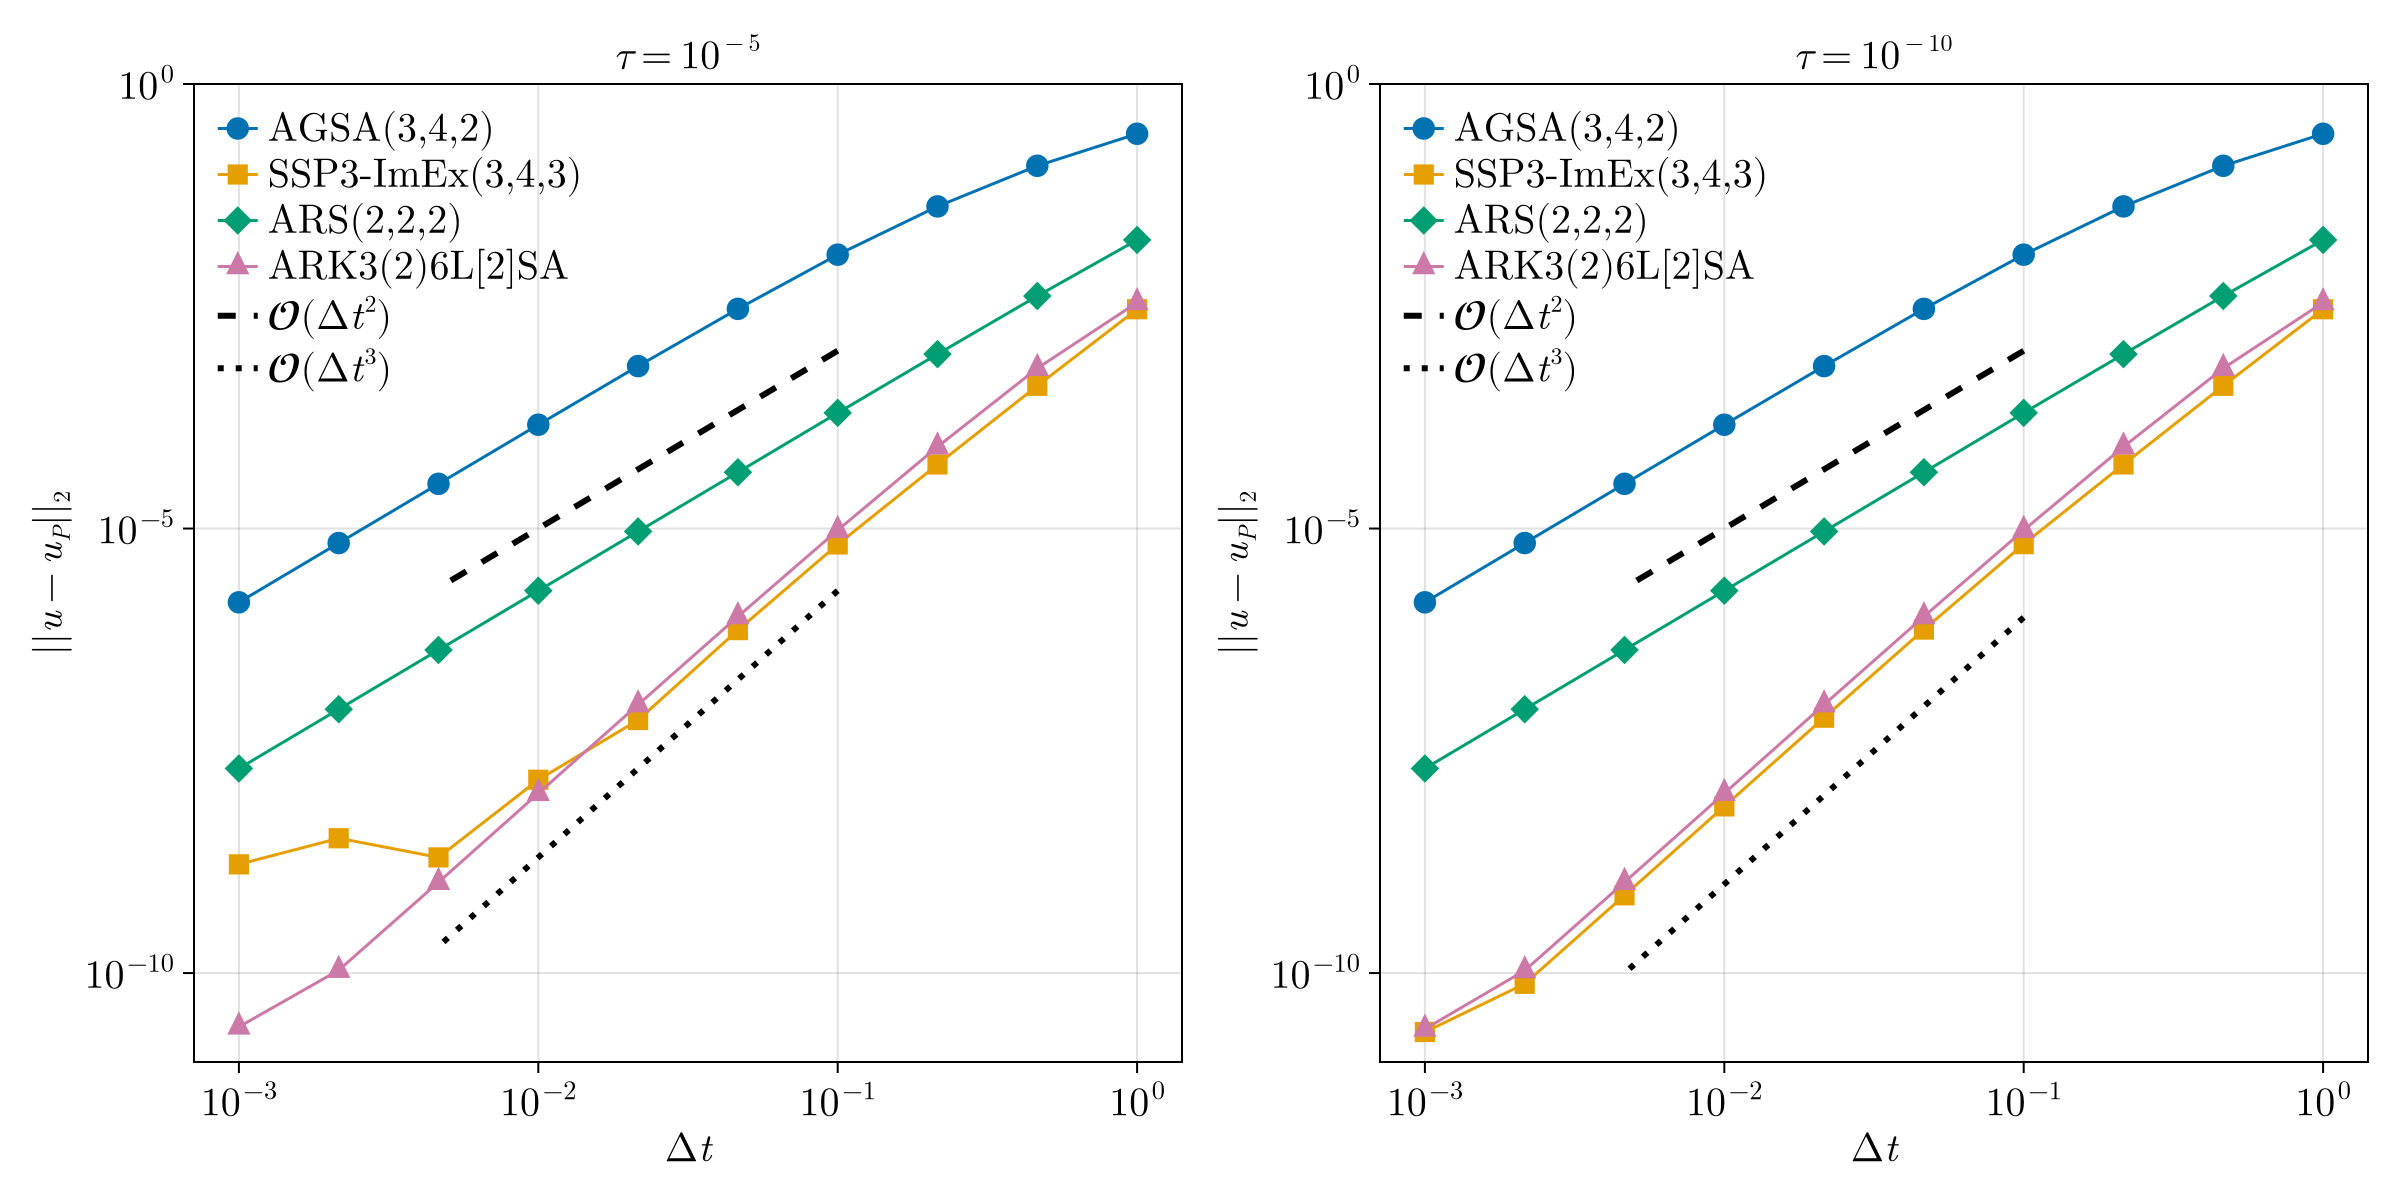

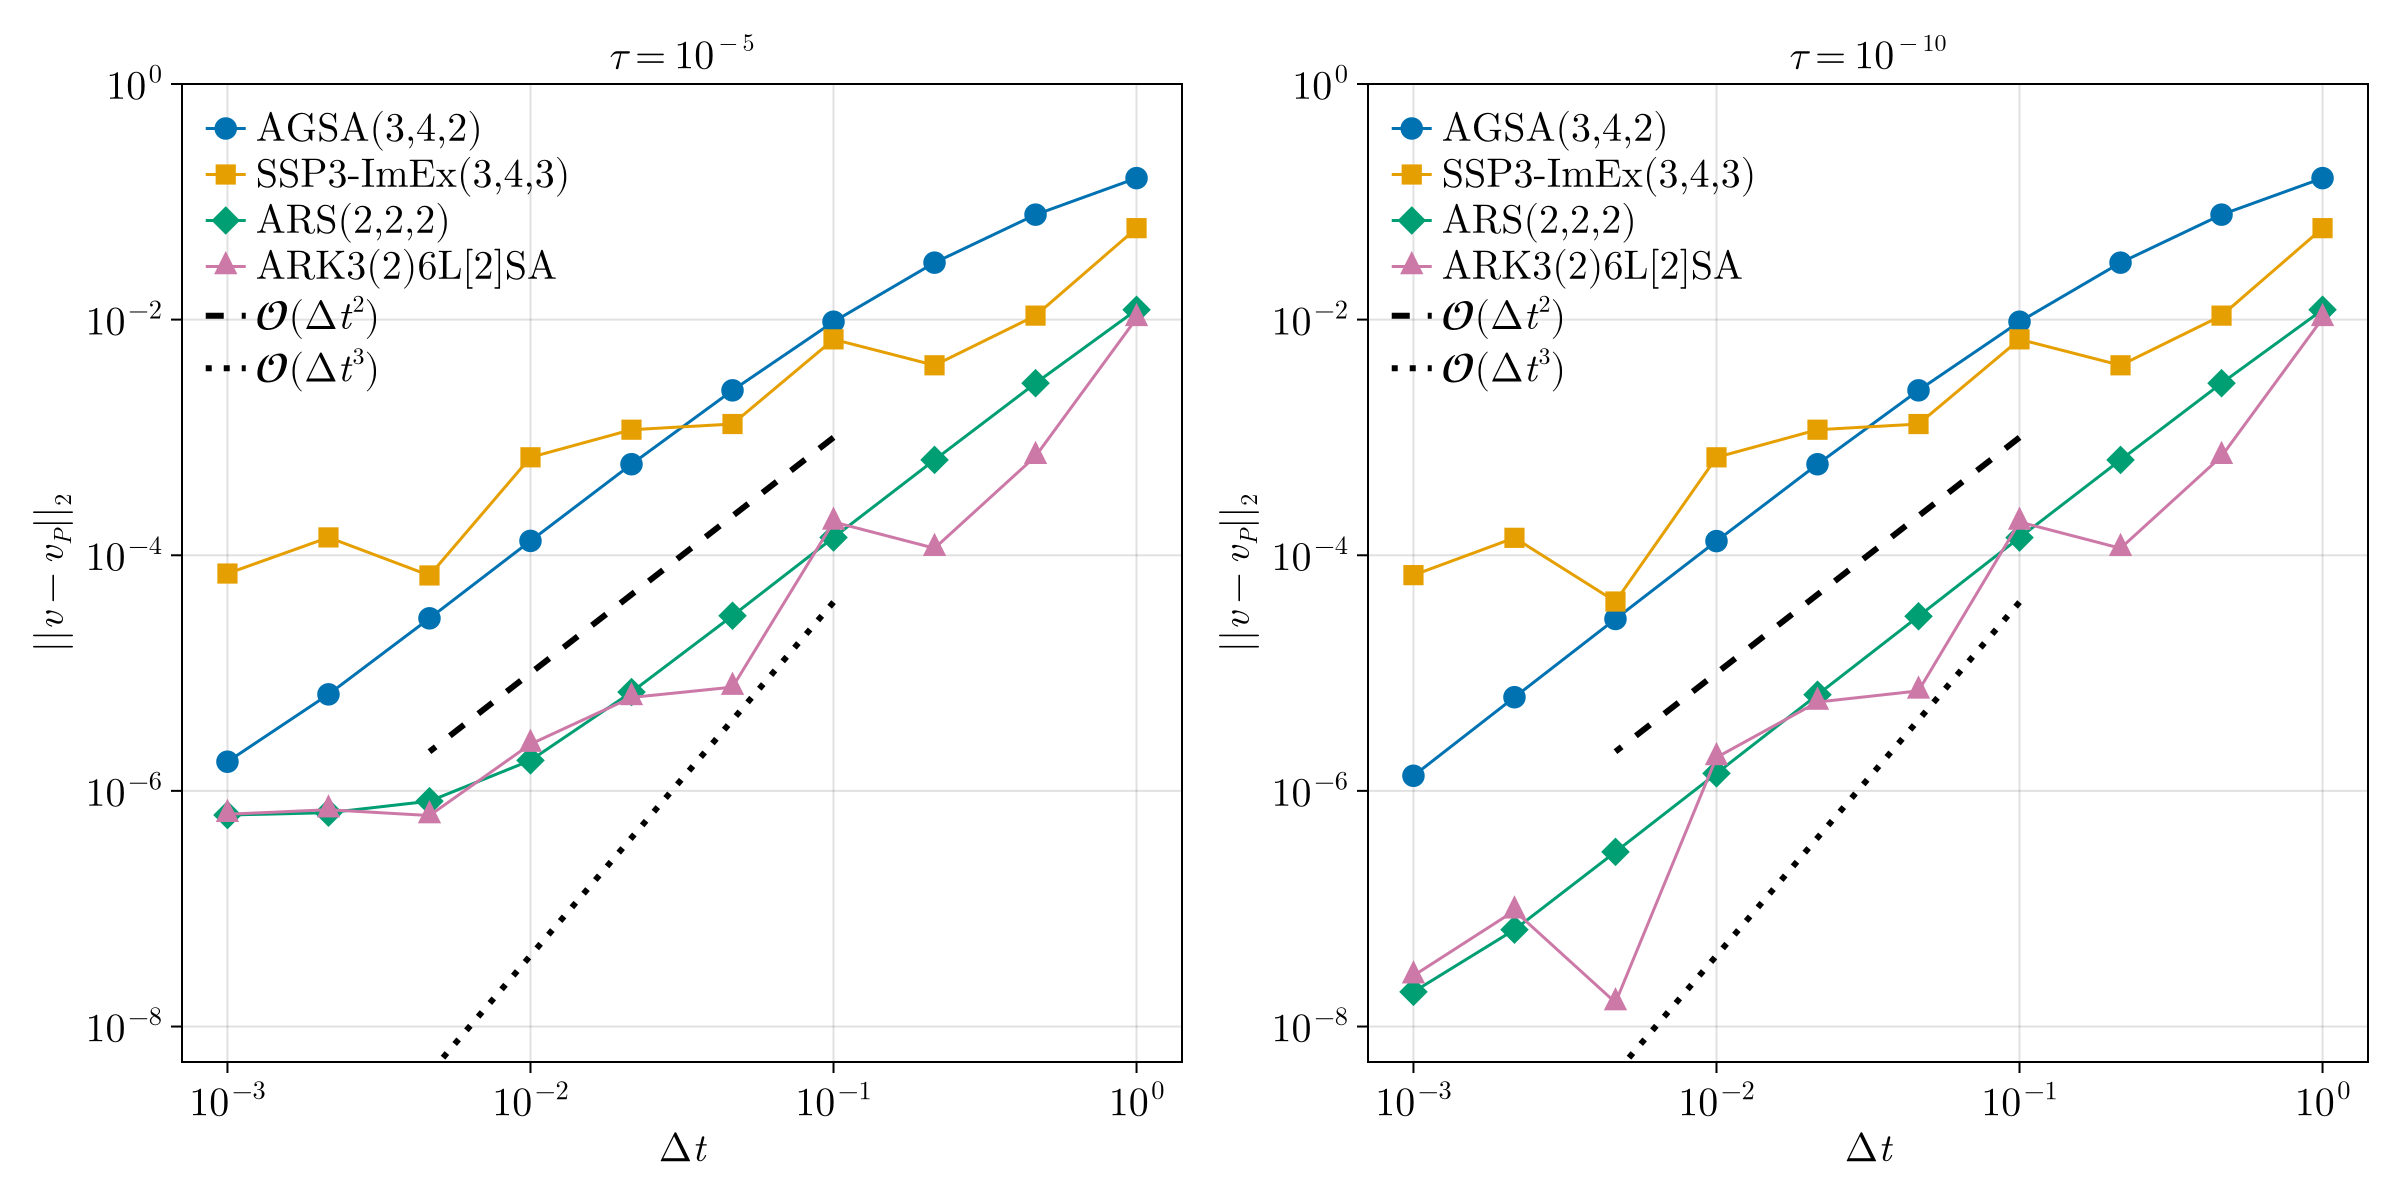

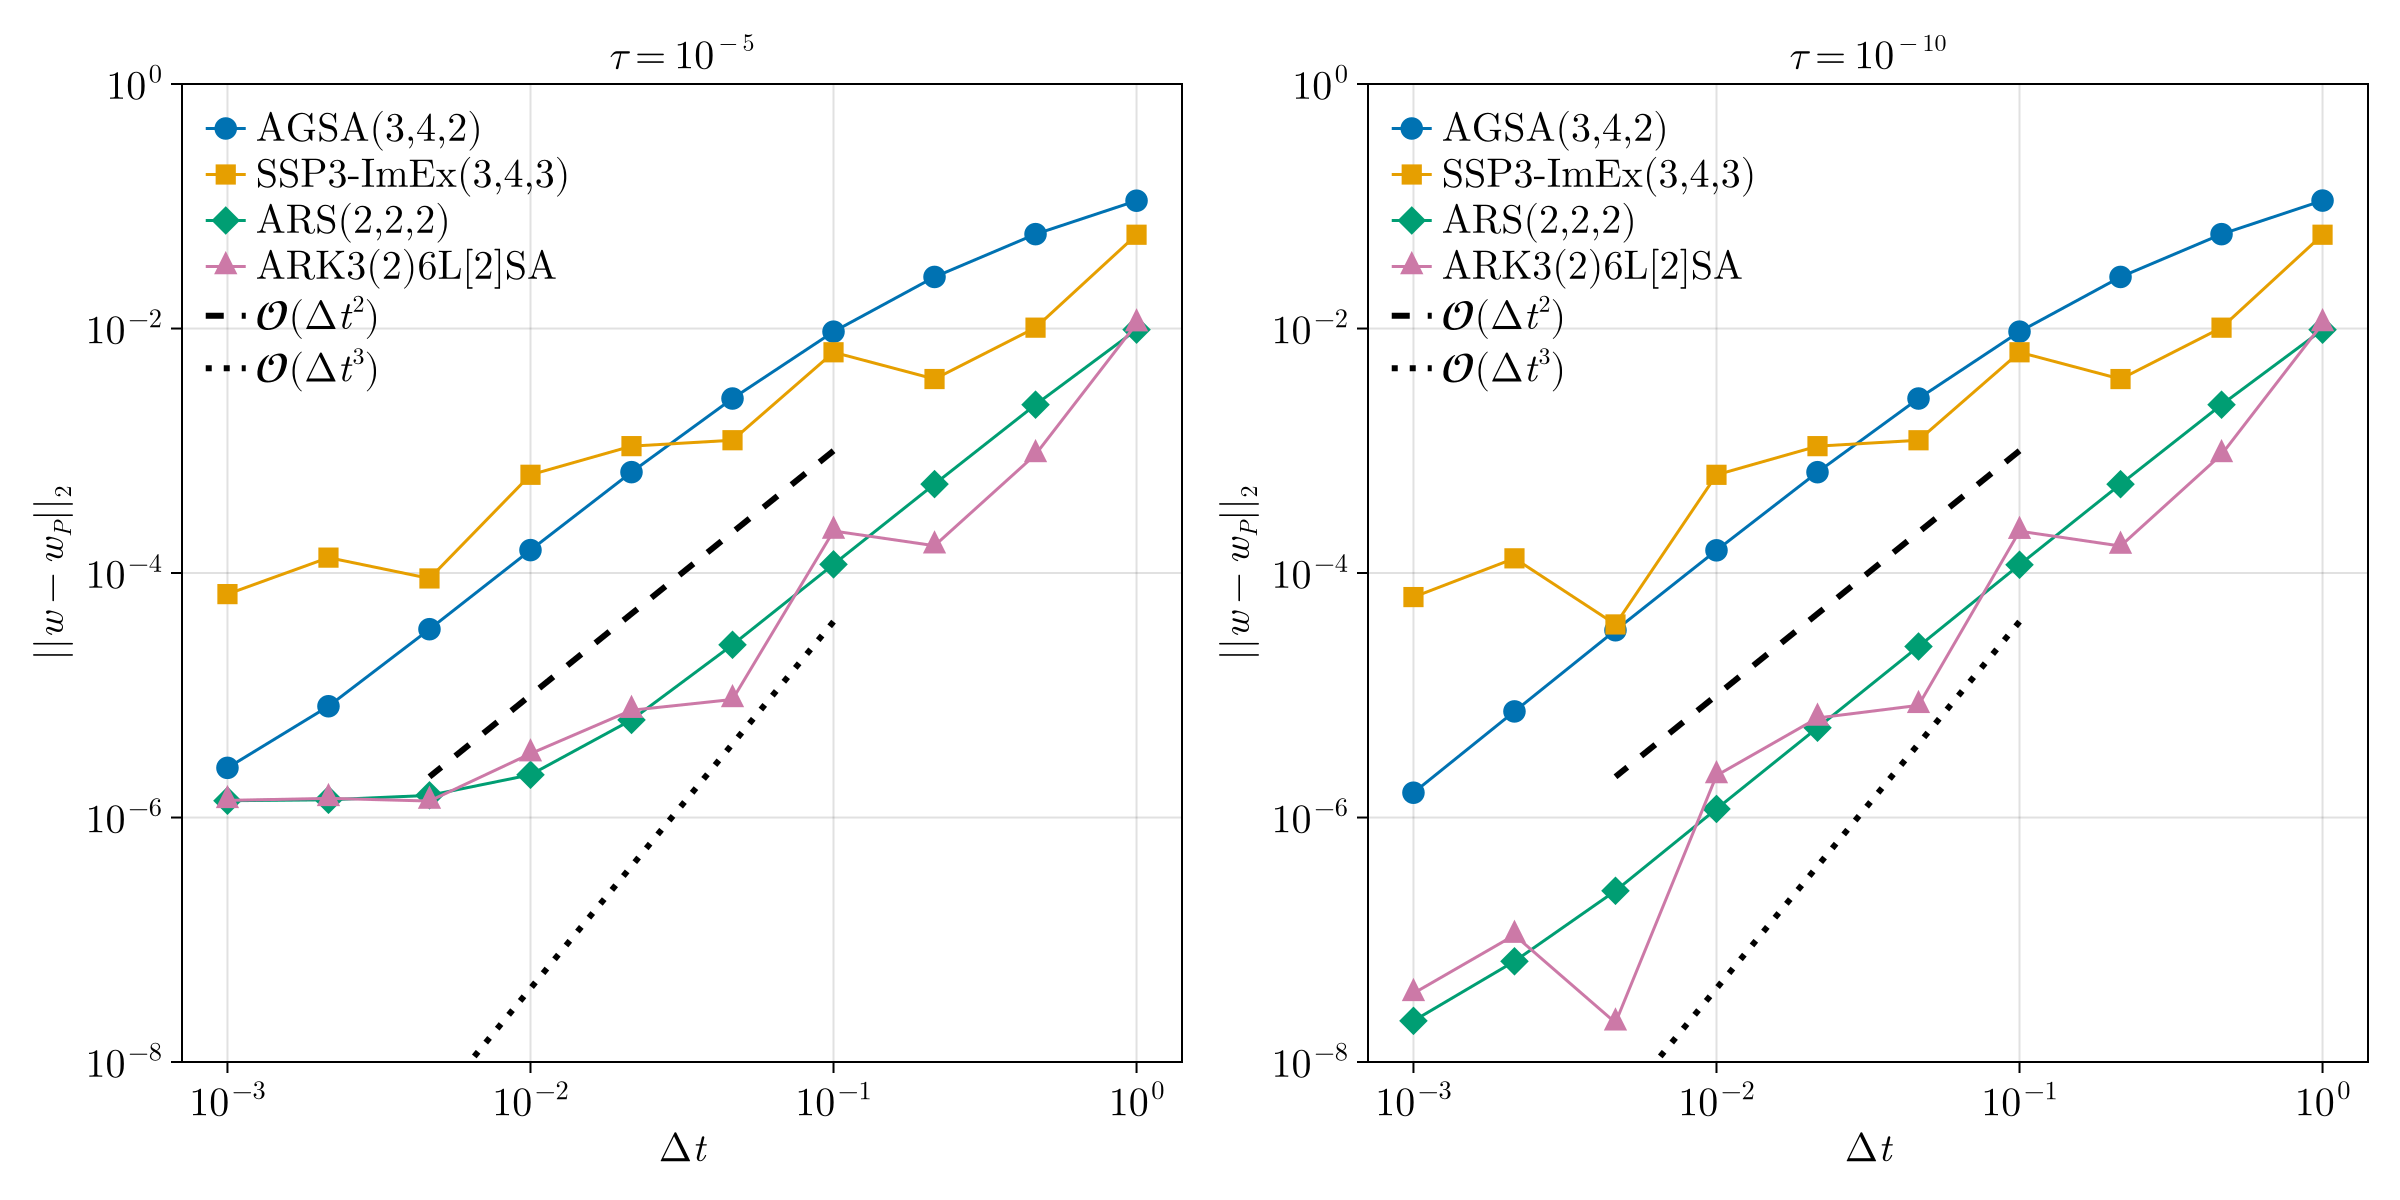

CairoMakie.Screen{IMAGE}


In [53]:
MthdNames = ["AGSA(3,4,2)", "SSP3-ImEx(3,4,3)", "ARS(2,2,2)", "ARK3(2)6L[2]SA"]
# Create the dictionary
MthdDict = Dict(zip(Mthds, MthdNames))
markers = [:circle, :rect, :diamond, :utriangle]

# Figure info
yl_u = [1.0e-11,1.0e-11]; yu_u = [1.0e0,1.0e0]
yl_v = [5.0e-9,5.0e-9]; yu_v = [1.0e0,1.0e0]
yl_w = [1.0e-8,1.0e-8]; yu_w = [1.0e0,1.0e0]

P = [2,3]; ST = [4 4; 4 4]; EN = [8 8; 8 8]
Fac_u = [1e-1 2.0e-3; 1.0e-1 1.0e-3]
Fac_v = [1e-1 4.0e-2; 1.0e-1 4.0e-2]
Fac_w = [1e-1 4.0e-2; 1.0e-1 4.0e-2]

fig_kdvh_AA_u = Figure(size = (1200, 600))
fig_kdvh_AA_v = Figure(size = (1200, 600))
fig_kdvh_AA_w = Figure(size = (1200, 600))

positions = [(1, 1), (1, 2)]

for (i, τ) in enumerate(τs)
    dts = DTs[i, :]
    τ_str = τ == 1.0 ? L"\tau = 1" : L"\tau = 10^{-%$(Int(-log10(τ)))}"
    # Create a new axis for each value of τ
    ax_u = Axis(fig_kdvh_AA_u[positions[i]...];
          xlabel = L"\Delta t", ylabel = L"$||u-u_{P}||_2$", title = τ_str,
          xscale = log10, yscale = log10)
    ax_v = Axis(fig_kdvh_AA_v[positions[i]...];
          xlabel = L"\Delta t", ylabel = L"$||v-v_{P}||_2$", title = τ_str,
          xscale = log10, yscale = log10)
    ax_w = Axis(fig_kdvh_AA_w[positions[i]...];
          xlabel = L"\Delta t", ylabel = L"$||w-w_{P}||_2$", title = τ_str,
          xscale = log10, yscale = log10)

    # Loop over methods and plot the error data for each method
    for (j, alg) in enumerate(Mthds)
        scatterlines!(ax_u, dts, errors_data_u[τ][alg]; label = MthdDict[alg], marker = markers[j])
        scatterlines!(ax_v, dts, errors_data_v[τ][alg]; label = MthdDict[alg], marker = markers[j])
        scatterlines!(ax_w, dts, errors_data_w[τ][alg]; label = MthdDict[alg], marker = markers[j])
    end

    # Add the reference scaling line after plotting the methods' data
    lines!(ax_u, dts[ST[i,1]:EN[i,1]], Fac_u[i,1] * dts[ST[i,1]:EN[i,1]].^(P[1]);
           label = L"\mathcal{O}(\Delta t^{%$(P[1])})", linestyle = :dash)
    lines!(ax_u, dts[ST[i,2]:EN[i,2]], Fac_u[i,2] * dts[ST[i,2]:EN[i,2]].^(P[2]);
           label = L"\mathcal{O}(\Delta t^{%$(P[2])})", linestyle = :dot)

    lines!(ax_v, dts[ST[i,1]:EN[i,1]], Fac_v[i,1] * dts[ST[i,1]:EN[i,1]].^(P[1]);
       label = L"\mathcal{O}(\Delta t^{%$(P[1])})", linestyle = :dash)
    lines!(ax_v, dts[ST[i,2]:EN[i,2]], Fac_v[i,2] * dts[ST[i,2]:EN[i,2]].^(P[2]);
       label = L"\mathcal{O}(\Delta t^{%$(P[2])})", linestyle = :dot)

    lines!(ax_w, dts[ST[i,1]:EN[i,1]], Fac_w[i,1] * dts[ST[i,1]:EN[i,1]].^(P[1]);
       label = L"\mathcal{O}(\Delta t^{%$(P[1])})", linestyle = :dash)
    lines!(ax_w, dts[ST[i,2]:EN[i,2]], Fac_w[i,2] * dts[ST[i,2]:EN[i,2]].^(P[2]);
       label = L"\mathcal{O}(\Delta t^{%$(P[2])})", linestyle = :dot)

    # Show the legend
    axislegend(ax_u, position = :lt, framevisible = false)
    axislegend(ax_v, position = :lt, framevisible = false)
    axislegend(ax_w, position = :lt, framevisible = false)
    ylims!(ax_u, yl_u[i], yu_u[i])
    ylims!(ax_v, yl_v[i], yu_v[i])
    ylims!(ax_w, yl_w[i], yu_w[i])
end

display(fig_kdvh_AA_u)
display(fig_kdvh_AA_v)
display(fig_kdvh_AA_w)

In [54]:
save(joinpath(save_path_1, "u_error_convergence_τ_all.pdf"), fig_kdvh_AA_u)
save(joinpath(save_path_1, "v_error_convergence_τ_all.pdf"), fig_kdvh_AA_v)
save(joinpath(save_path_1, "w_error_convergence_τ_all.pdf"), fig_kdvh_AA_w)

CairoMakie.Screen{PDF}


In [25]:
tspan

(0.0, 4.800000000000001)

### Error growth plots for different methods, with and without RK relaxation, applied to $\text{KdVH}(\tau)$, with the exact solution computed using the Petviashvili method.

In [26]:
function kdvh_exact_solitary_wave_error_growth(; domain_traversals = 2,
                                                 τ = 1.0e-2,
                                                 xmin = -40.0,
                                                 xmax = 40.0,
                                                 c = 1.2,
                                                 accuracy_order = 8, N = 2^8,
                                                 alg = ARS443(), dt = 0.01,
                                                 kwargs...)


    # Reference solution by Petviashvili algorithm
    λ = 1/τ; N_ref = 2^10
    x, u0 = petviashvili_kdvh(; xmin = xmin, xmax = xmax, λ = λ, c = c, N = N_ref, maxiter = 1000, tol = 1.0e-12)

    u0itp = LinearInterpolation((x,), u0, extrapolation_bc = Periodic())
    function u_traveling(t, x::Number, equation)
        x_t = mod(x - c * t - xmin, xmax - xmin) + xmin
        u0itp(x_t)
    end
    function u_traveling(t, x::AbstractVector, equation)
        u_traveling.(t, x, equation)
    end


    # Initialization of physical and numerical parameters
    tspan = (0.0, domain_traversals * (xmax - xmin) / c)

    D1 = upwind_operators(periodic_derivative_operator;
       derivative_order = 1, accuracy_order,
       xmin, xmax, N)

    # Setup plot
    fig_err = Figure()
    ax = Axis(fig_err[1, 1]; xlabel = L"t", ylabel = L"Error of $u$",
              xscale = log10, yscale = log10)

    # Setup callback computing the error
    series_t = Vector{Float64}()
    series_error = Vector{Float64}()
    callback = let series_t = series_t, series_error = series_error
        function (q, parameters, t)
            (; tmp, equation) = parameters

            u = get_u(q, equation)
            u_ref = u_traveling(t, grid(parameters.D1), HyperbolizedKdV(τ))

            @. tmp = u - u_ref
            err = integrate(abs2, tmp, parameters.D1) |> sqrt

            push!(series_t, t)
            push!(series_error, err)
            return nothing
        end
    end


    # HyperbolizedKdV with IMEX
    let equation = HyperbolizedKdV(τ)
        (; q0, parameters) = setup(u_traveling, HyperbolizedKdV(τ), tspan, D1)

        @info "Hyperbolized KdV without relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, kwargs...)
        lines!(ax, series_t, series_error;
               label = "KdVH($τ), baseline")

        @info "Hyperbolized KdV with relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, relaxation = true, kwargs...)
        lines!(ax, series_t, series_error;
               label = "KdVH($τ), relaxation")
    end
    n = length(series_t)
    st_ind1 = round(Int, 0.05 * n)
    st_ind2 = round(Int, 0.2 * n)

    println("st_ind1 = ", st_ind1)
    println("st_ind2 = ", st_ind2)

    # Use the start index to slice the array from 20% to the end
    lines!(ax, series_t[st_ind1:100:end], 1e-3 * series_t[st_ind1:100:end];
           label = L"\mathcal{O}(t)", linestyle = :dash)
    lines!(ax, series_t[st_ind1:100:st_ind2], 4e-4 * series_t[st_ind1:100:st_ind2].^ 2;
           label = L"\mathcal{O}(t^2)", linestyle = :dot)

    axislegend(ax, position = :lt, framevisible = false)

    return fig_err
end

kdvh_exact_solitary_wave_error_growth (generic function with 1 method)

┌ Info: Converged
│   iter = 55
└   res = 9.983125437429408e-13
[ Info: Hyperbolized KdV without relaxation


  0.505741 seconds (454.67 k allocations: 50.772 MiB, 2.48% gc time, 31.39% compilation time)


[ Info: Hyperbolized KdV with relaxation


  0.329702 seconds (92.83 k allocations: 27.128 MiB, 1.39% compilation time)
st_ind1 = 336
st_ind2 = 1343


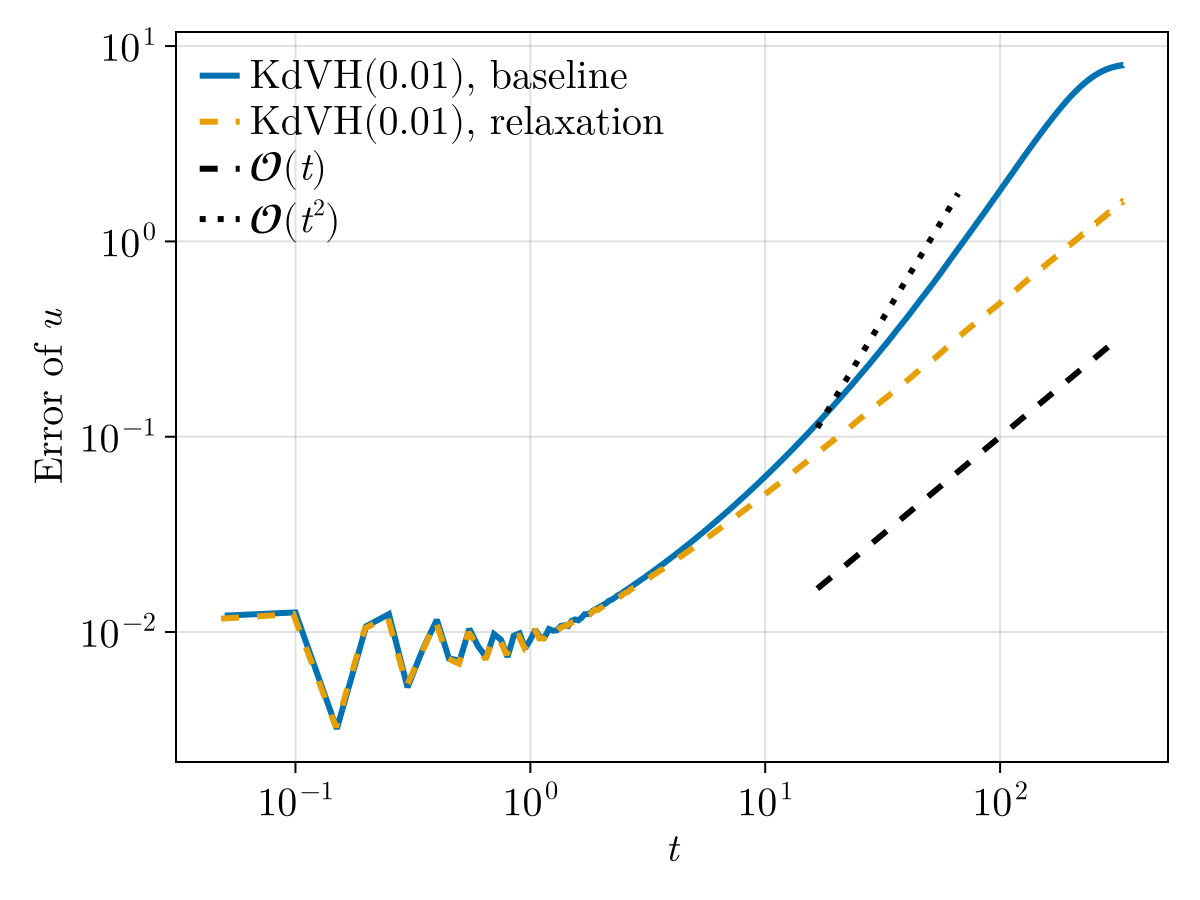

In [27]:
τ = 1.0e-2; xmin = -40.0; xmax = 40.0; c = 1.2; ImEx_name = "SSP2ImEx222"
fig_kdvh_err = kdvh_exact_solitary_wave_error_growth(; domain_traversals = 5,
                                                  τ = τ,
                                                  xmin = xmin,
                                                  xmax = xmax,
                                                  c = c,
                                                  accuracy_order = 8, N = 2^8,
                                                  alg = SSP2ImEx222(), dt = 0.05)

In [28]:
# Saving the file
using Printf
save(joinpath(save_path_1, "KdVH_Err_growth_" * ImEx_name * "_τ_$(@sprintf("%.1e", τ))_c_$(@sprintf("%.1f", c)).pdf"), fig_kdvh_err)


CairoMakie.Screen{PDF}


┌ Info: Converged
│   iter = 55
└   res = 9.983125437429408e-13
[ Info: Hyperbolized KdV without relaxation


  0.523083 seconds (266.40 k allocations: 38.225 MiB, 2.06% gc time, 32.24% compilation time)


[ Info: Hyperbolized KdV with relaxation


  0.339825 seconds (92.93 k allocations: 29.769 MiB, 1.30% compilation time)
st_ind1 = 336
st_ind2 = 1343


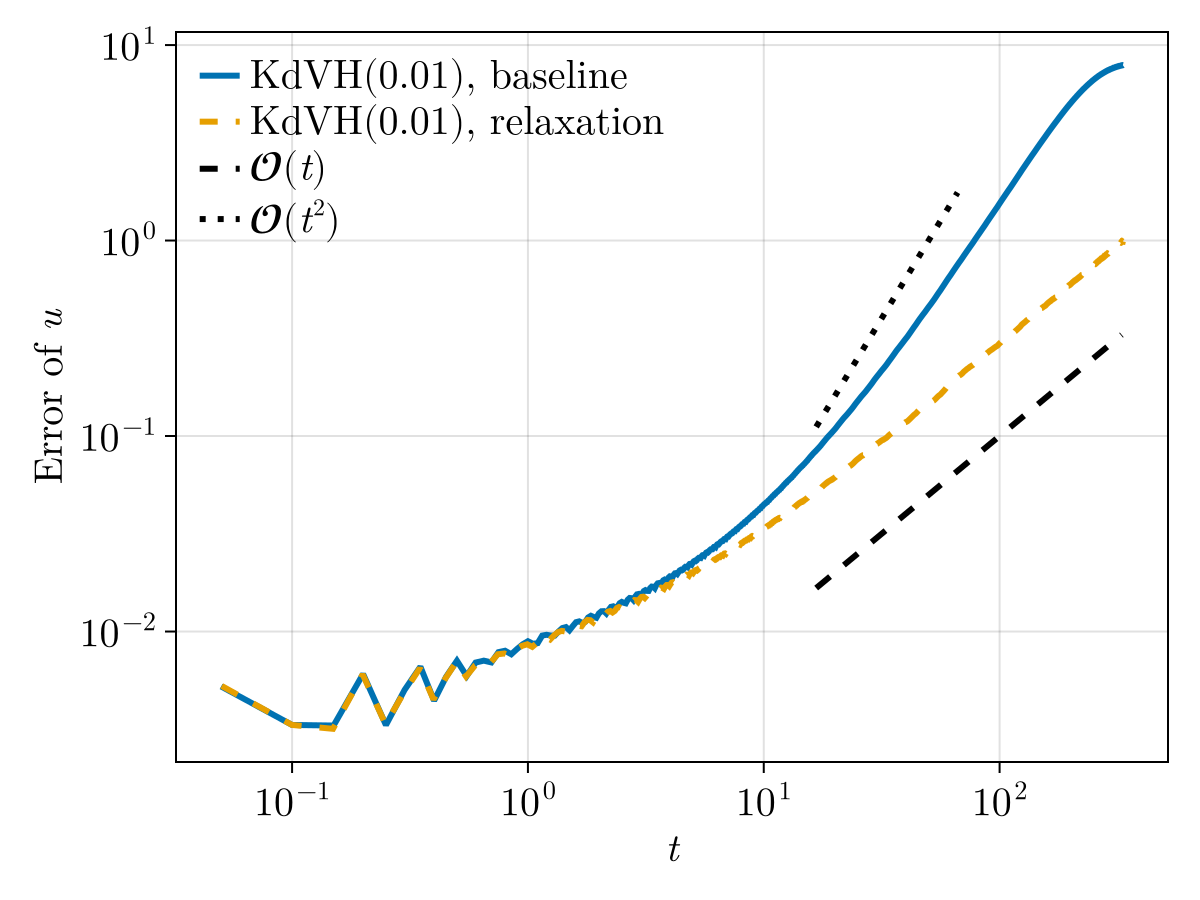

In [29]:
τ = 1.0e-2; xmin = -40.0; xmax = 40.0; c = 1.2; ImEx_name = "ARS222"
fig_kdvh_err = kdvh_exact_solitary_wave_error_growth(; domain_traversals = 5,
                                                  τ = τ,
                                                  xmin = xmin,
                                                  xmax = xmax,
                                                  c = c,
                                                  accuracy_order = 8, N = 2^8,
                                                  alg = ARS222(), dt = 0.05)

In [30]:
# Saving the file
save(joinpath(save_path_1, "KdVH_Err_growth_" * ImEx_name * "_τ_$(@sprintf("%.1e", τ))_c_$(@sprintf("%.1f", c)).pdf"), fig_kdvh_err)


CairoMakie.Screen{PDF}


### RK relaxation on $\text{KdVH}(\tau)$ to verify linear and quadratic error convergence using conservative versus non-conservative methods.

The error growth of the solutions for the KdV and $\text{KdVH}(\tau)$ systems is analyzed by comparing conservative methods using RK relaxation with non-conservative methods. This approach demonstrates linear error convergence for conservative methods and quadratic error convergence for non-conservative methods. In each case, the numerical solution is compared to the analytical solution of the KdV equation.

In the figure, we will observe:

- Error of the time-stepping method without relaxation for the KdV solution with respect to the KdV analytical solution.
- Error of the time-stepping method with relaxation for the KdV solution with respect to the KdV analytical solution.
- Error of the time-stepping method without relaxation for the KdVH solution (with a particular $\tau$) with respect to the KdV analytical solution.
- Error of the time-stepping method with relaxation for the KdVH solution (with a particular $\tau$) with respect to the KdV analytical solution.

In [31]:
function kdvh_kdv_solitary_wave_error_growth(; τ = 1.0e-4,
                                              domain_traversals = 10,
                                              accuracy_order = 8, N = 2^10,
                                              alg = ARS443(), dt = 0.025,
                                              kwargs...)
    # Initialization of physical and numerical parameters
    (; xmin, xmax, c) = solitary_wave_setup()
    tspan = (0.0, domain_traversals * (xmax - xmin) / c)

    D1 = upwind_operators(periodic_derivative_operator;
                          derivative_order = 1, accuracy_order,
                          xmin, xmax, N)
        # This provides the D3 aw well in case of KdV equation,  I checked.

    # Setup plot
    fig_err = Figure()
    ax = Axis(fig_err[1, 1]; xlabel = L"t", ylabel = L"Error of $u$",
              xscale = log10, yscale = log10)


    # Setup callback computing the error
    series_t = Vector{Float64}()
    series_error = Vector{Float64}()
    callback = let series_t = series_t, series_error = series_error
        function (q, parameters, t)
            (; tmp, equation) = parameters

            u = get_u(q, equation)
            u_ref = solitary_wave_solution(t, grid(parameters.D1), KdV())

            @. tmp = u - u_ref
            err = integrate(abs2, tmp, parameters.D1) |> sqrt

            push!(series_t, t)
            push!(series_error, err)
            return nothing
        end
    end


    # KdV
    let equation = KdV()
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)

        @info "KdV without relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, kwargs...)
        lines!(ax, series_t, series_error;
               label = "KdV, baseline")

        @info "KdV with relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, relaxation = true, kwargs...)
        lines!(ax, series_t, series_error;
               label = "KdV, relaxation")
    end


    # HyperbolizedKdV with IMEX
    let equation = HyperbolizedKdV(τ)
        (; q0, parameters) = setup(solitary_wave_solution, equation,
                                   tspan, D1)

        @info "Hyperbolized KdV without relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, kwargs...)
        lines!(ax, series_t, series_error;
               label = "KdVH, baseline")

        @info "Hyperbolized KdV with relaxation"
        empty!(series_t)
        empty!(series_error)
        @time sol = solve_imex(rhs_stiff!, operator(rhs_stiff!, parameters),
                               rhs_nonstiff!,
                               q0, tspan, parameters, alg;
                               dt, callback, relaxation = true, kwargs...)
        lines!(ax, series_t, series_error;
               label = "KdVH, relaxation")
    end

    # Use the start index to slice the array from 20% to the end
    n = length(series_t)
    st_ind1 = round(Int, 0.05 * n)
    st_ind2 = round(Int, 0.2 * n)
    lines!(ax, series_t[st_ind1:100:end], 1e-3 * series_t[st_ind1:100:end];
           label = L"\mathcal{O}(t)", linestyle = :dash)
    lines!(ax, series_t[st_ind1:100:st_ind2], 4e-4 * series_t[st_ind1:100:st_ind2].^ 2;
           label = L"\mathcal{O}(t^2)", linestyle = :dot)

    axislegend(ax, position = :lt, framevisible = false)

    return fig_err
end

kdvh_kdv_solitary_wave_error_growth (generic function with 1 method)

[ Info: KdV without relaxation


  0.574490 seconds (216.38 k allocations: 29.909 MiB, 22.69% compilation time)


[ Info: KdV with relaxation


  0.455636 seconds (34.50 k allocations: 18.067 MiB, 2.89% gc time, 0.92% compilation time)


[ Info: Hyperbolized KdV without relaxation


  0.736489 seconds (281.42 k allocations: 39.732 MiB, 18.47% compilation time)


[ Info: Hyperbolized KdV with relaxation


  0.607427 seconds (38.60 k allocations: 23.948 MiB, 0.68% compilation time)


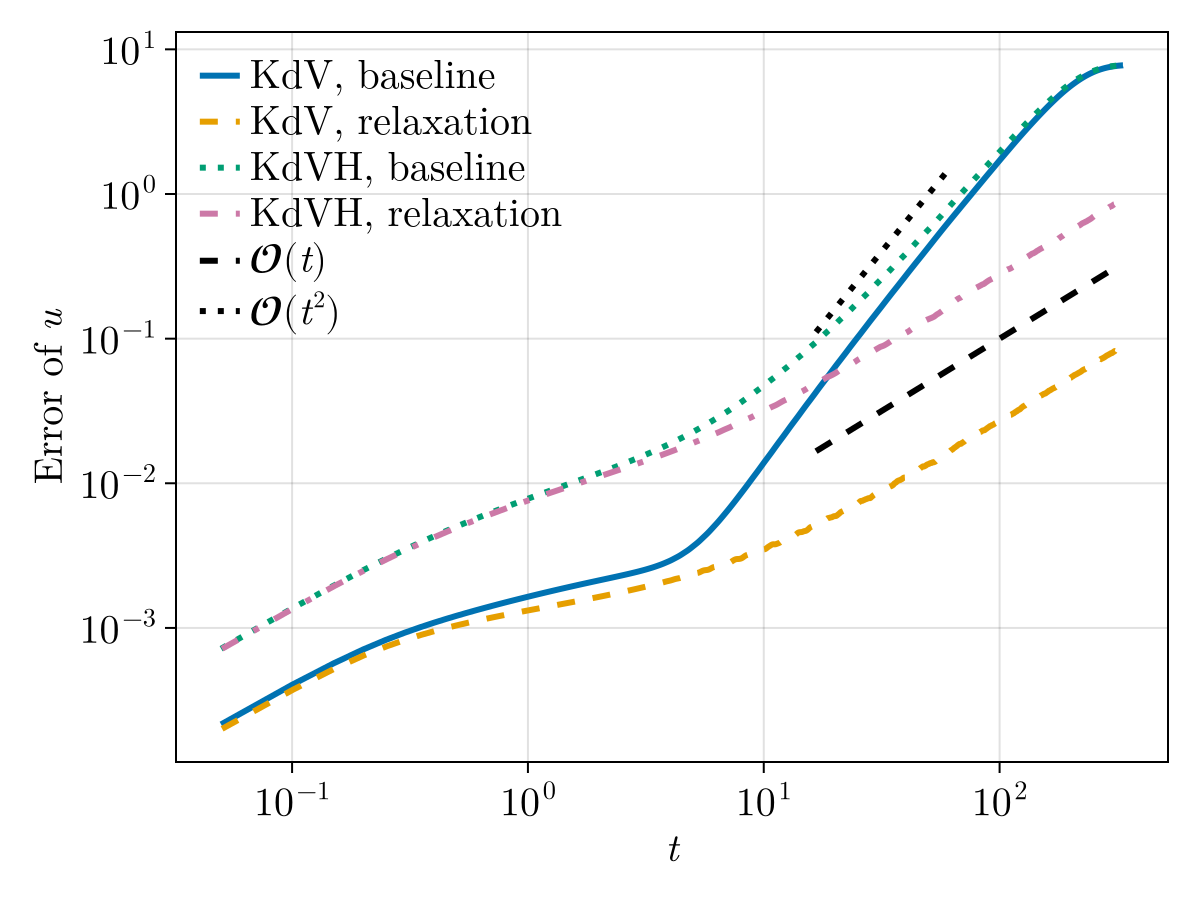

In [32]:
τ = 1.0e-3; ImEx_name = "ARS443"
fig_err = kdvh_kdv_solitary_wave_error_growth(; τ = τ,
                                              domain_traversals = 5,
                                              accuracy_order = 8, N = 2^8,
                                              alg = ARS443(), dt = 0.05)


In [33]:
# Saving the file
save(joinpath(save_path_1, "Err_growth_" * ImEx_name * "_τ_$(@sprintf("%.1e", τ)).pdf"), fig_err)


CairoMakie.Screen{PDF}


[ Info: KdV without relaxation


  0.437457 seconds (33.66 k allocations: 18.367 MiB)


[ Info: KdV with relaxation


  0.435477 seconds (33.32 k allocations: 17.984 MiB)


[ Info: Hyperbolized KdV without relaxation


  0.616533 seconds (37.76 k allocations: 25.142 MiB, 1.25% gc time)


[ Info: Hyperbolized KdV with relaxation


  0.598965 seconds (37.43 k allocations: 24.997 MiB)


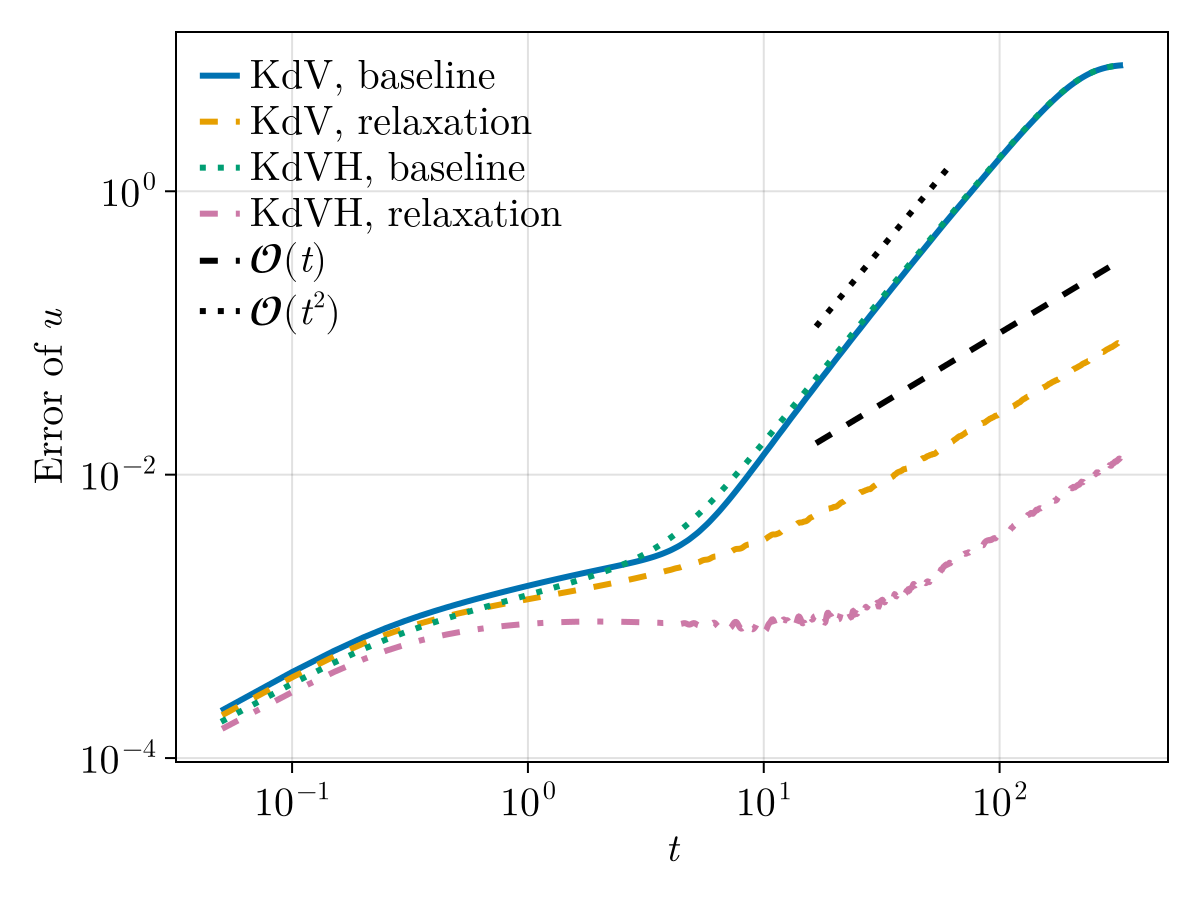

In [34]:
τ = 1.0e-4; ImEx_name = "ARS443"
fig_err = kdvh_kdv_solitary_wave_error_growth(; τ = τ,
                                              domain_traversals = 5,
                                              accuracy_order = 8, N = 2^8,
                                              alg = ARS443(), dt = 0.05)


In [35]:
# Saving the file
save(joinpath(save_path_1, "Err_growth_" * ImEx_name * "_τ_$(@sprintf("%.1e", τ)).pdf"), fig_err)


CairoMakie.Screen{PDF}


[ Info: KdV without relaxation


  0.441742 seconds (33.66 k allocations: 18.367 MiB)


[ Info: KdV with relaxation


  0.435449 seconds (33.32 k allocations: 17.984 MiB)


[ Info: Hyperbolized KdV without relaxation


  1.220823 seconds (37.75 k allocations: 27.407 MiB)


[ Info: Hyperbolized KdV with relaxation


  1.221935 seconds (37.45 k allocations: 26.129 MiB, 0.80% gc time)


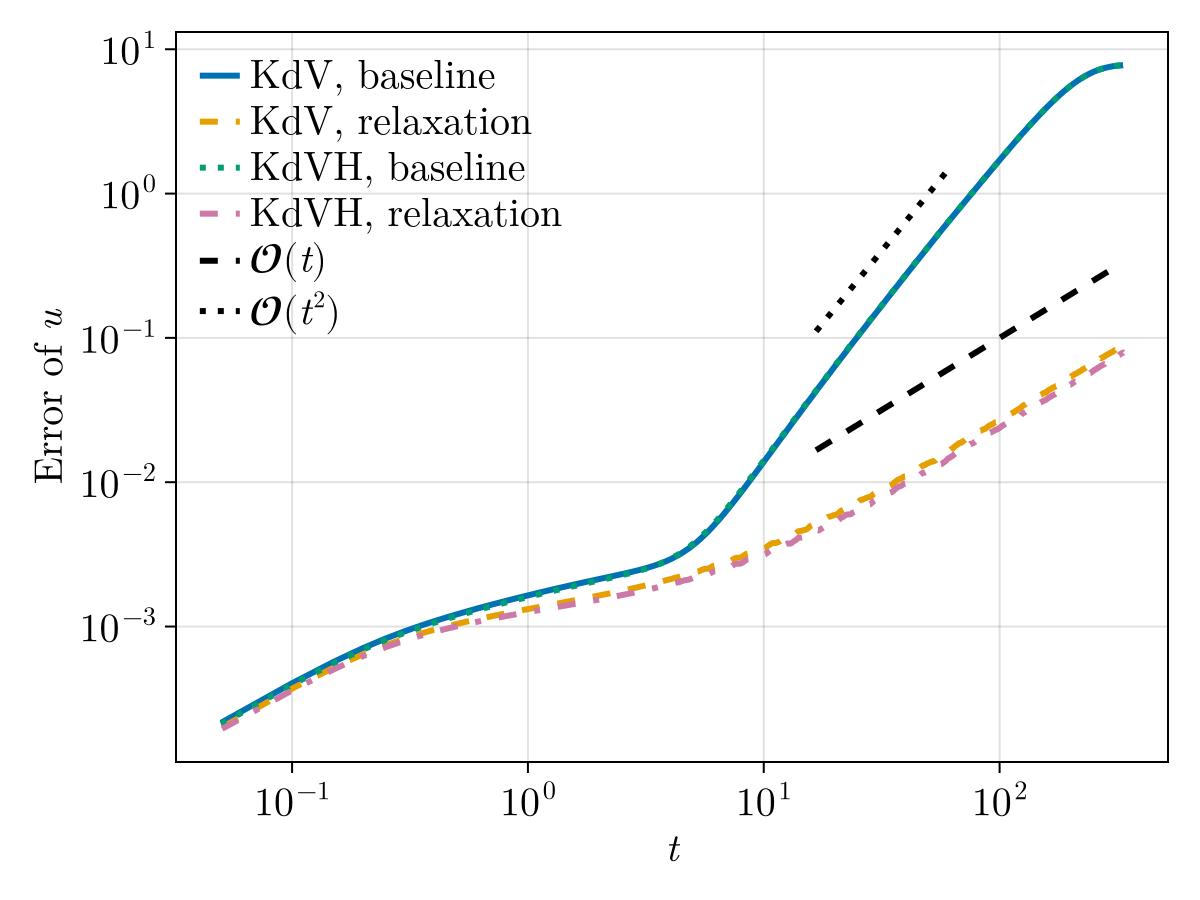

In [36]:
τ = 1.0e-5; ImEx_name = "ARS443"
fig_err = kdvh_kdv_solitary_wave_error_growth(; τ = τ,
                                              domain_traversals = 5,
                                              accuracy_order = 8, N = 2^8,
                                              alg = ARS443(), dt = 0.05)


In [37]:
# Saving the file
save(joinpath(save_path_1, "Err_growth_" * ImEx_name * "_τ_$(@sprintf("%.1e", τ)).pdf"), fig_err)


CairoMakie.Screen{PDF}


[ Info: KdV without relaxation


  0.445749 seconds (33.66 k allocations: 18.367 MiB, 1.61% gc time)


[ Info: KdV with relaxation


  0.436362 seconds (33.32 k allocations: 17.984 MiB)


[ Info: Hyperbolized KdV without relaxation


  1.230898 seconds (37.75 k allocations: 27.409 MiB)


[ Info: Hyperbolized KdV with relaxation


  1.211095 seconds (37.43 k allocations: 27.263 MiB)


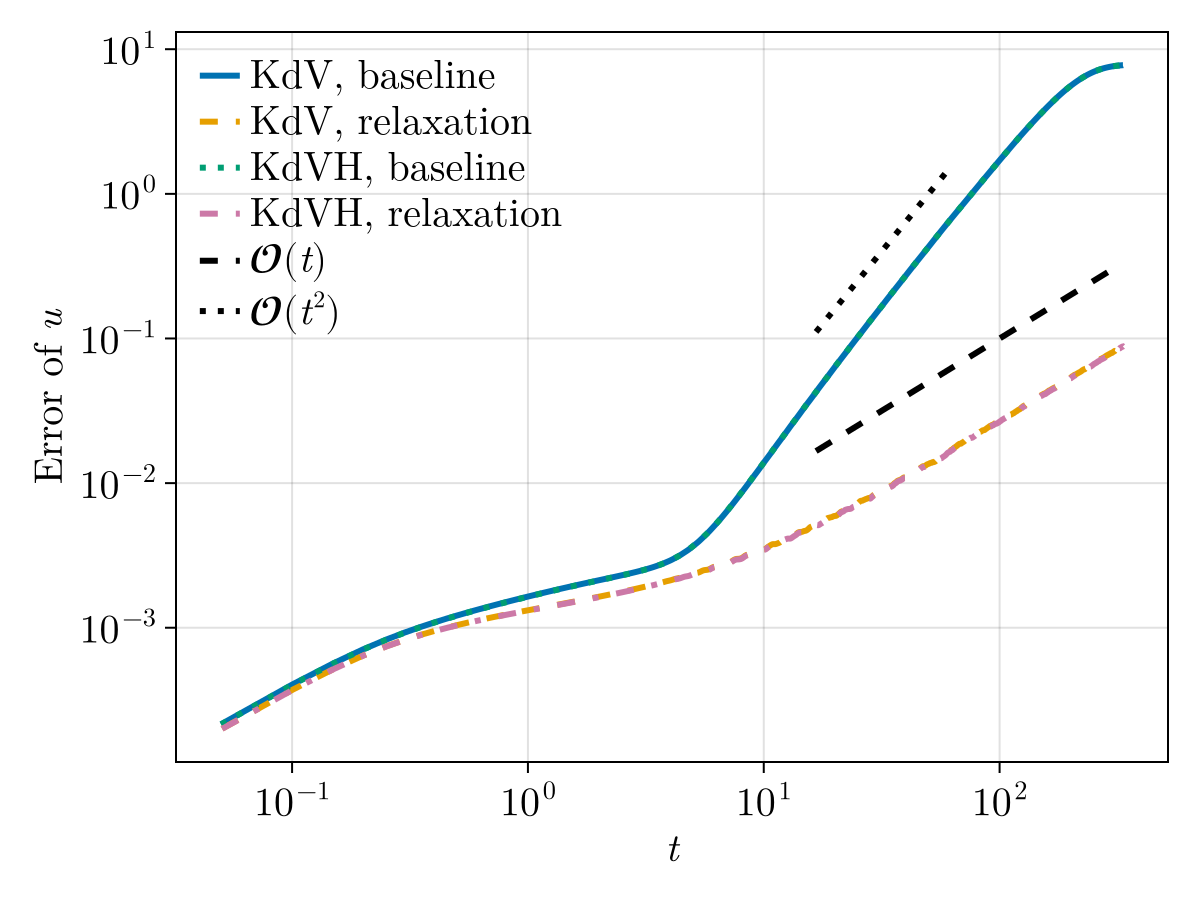

In [38]:
τ = 1.0e-6; ImEx_name = "ARS443"
fig_err = kdvh_kdv_solitary_wave_error_growth(; τ = τ,
                                              domain_traversals = 5,
                                              accuracy_order = 8, N = 2^8,
                                              alg = ARS443(), dt = 0.05)


In [39]:
# Saving the file
save(joinpath(save_path_1, "Err_growth_" * ImEx_name * "_τ_$(@sprintf("%.1e", τ)).pdf"), fig_err)


CairoMakie.Screen{PDF}
